In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as st
from multiprocessing import Pool
from sklearn.decomposition import PCA
from tqdm import tqdm

#Save
import json, h5py
import scipy.io as sio

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

#Predictive Coding Github Repository
sys.path.append('/home/dwyrick/Git/openscope_predictive_coding/')
from openscope_predictive_coding.ophys.dataset.openscope_predictive_coding_dataset import OpenScopePredictiveCodingDataset
from openscope_predictive_coding.ophys.response_analysis.response_analysis import ResponseAnalysis

#User
import openscope_predictive_coding.ophys.decoding_analysis.decoding as dc
import openscope_predictive_coding.ophys.response_analysis.utilities as openscope_utils

#Params
mainseq_ids = [68, 78, 13, 26]
oddball_ids = [6, 17, 22, 51, 71, 89, 103, 110, 111, 112]
all_ids = np.concatenate((mainseq_ids,oddball_ids))
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/'
PlotDir = os.path.join(SaveDir,'plots')

areanames = ['VISp', 'VISpm','RSP']
mainseq_labels = ['A','B','C','D']
blocknames = ['randomized_control_pre','oddball','transition_control','randomized_control_post']
stimulus_blocks = ['randomized_control_pre','oddball','transition_control','randomized_control_post']
blocklabels = ['Rand-Ctrl-Pre', 'Oddball', 'Trans-Ctrl', 'Rand-Ctrl-Post']

import warnings
warnings.filterwarnings("ignore")

In [2]:
color_names=['windows blue',
             'red',
             'amber',
             'faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

In [6]:
# data streams for each imaging session are saved as .h5 files in each folder's experiment in this directory
cache_dir = '/srv/data/AllenInst/opc_analysis'

# Read in experiment manifest
manifest_file = '/srv/data/AllenInst/opc_analysis/opc_production_manifest.xlsx'
manifest = pd.read_excel(manifest_file)

# limit to experiments that passed QC
manifest = manifest[manifest['experiment_state']=='passed']
areanames = np.unique(manifest['imaging_area'])

data = sio.loadmat('/home/dwyrick/projects/predictive_coding/data/preferredStim.mat')
preferred_imageIDs = data['preferred_imageIDs'][0]
cellIDs = data['cellIDs'][0]

cell_metadata_df = pd.read_csv('/home/dwyrick/projects/predictive_coding/cell_metadata.csv')
cell_metadata_df.drop(columns='Unnamed: 0',inplace=True)
cell_metadata_df.drop_duplicates(subset='cell_specimen_id',inplace=True)
cell_metadata_df.set_index('cell_specimen_id', drop=True, inplace=True)


pIDs = []
for cellID in cell_metadata_df.index.values:
    
    indy = np.where(cellIDs == cellID)[0][0]
    pID = preferred_imageIDs[indy]
    pIDs.append(pID)
    
cell_metadata_df['pref_stim'] = pIDs

os.chdir('/home/dwyrick/projects/predictive_coding')
os.getcwd()

'/home/dwyrick/projects/predictive_coding'

## Tracing decoding


In [ ]:
randctrl_labeled_rsponses = {'FF': {},'FB': {}}
transctrl_labeled_rsponses = {'FF': {},'FB': {}}
oddball_labeled_rsponses = {'FF': {},'FB': {}}

for ii, area in enumerate(areanames):
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth_FF = cell_metadata_df[(cell_metadata_df['location'] == locstr) & (cell_metadata_df['retrogradely_labeled'] == True) & (cell_metadata_df['projection_pathway'] == 'FF')].index.values
        
        if len(cell_ids_perdepth_FF) > 0:
            randctrl_labeled_rsponses['FF'][locstr] = [randctrl_pseudopop_responses[area][0].loc[:,cell_ids_perdepth_FF], randctrl_pseudopop_responses[area][1].loc[:,cell_ids_perdepth_FF]]
            transctrl_labeled_rsponses['FF'][locstr] = transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth_FF]
            oddball_labeled_rsponses['FF'][locstr] = oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth_FF]
           
        cell_ids_perdepth_FB = cell_metadata_df[(cell_metadata_df['location'] == locstr) & (cell_metadata_df['retrogradely_labeled'] == True) & (cell_metadata_df['projection_pathway'] == 'FB')].index.values
        if len(cell_ids_perdepth_FB) > 0:
            randctrl_labeled_rsponses['FB'][locstr] = [randctrl_pseudopop_responses[area][0].loc[:,cell_ids_perdepth_FB], randctrl_pseudopop_responses[area][1].loc[:,cell_ids_perdepth_FB]]
            transctrl_labeled_rsponses['FB'][locstr] = transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth_FB]
            oddball_labeled_rsponses['FB'][locstr] = oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth_FB]
            
        

In [ ]:
#Let's decode stimulus blocks from each other based on responses to MS images

method='kfold'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))



classifier = 'nearest_neighbor'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
fstr = 'pseudopop'
PlotDir = os.path.join(SaveDir,'plots')



# fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey/=True,sharex=True)

for tracing in ['FF','FB']:
    for ii, area in enumerate(areanames):
        cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values

        #Loop over depth as well
        for jj,depthstr in enumerate(['superficial','deep']):
            locstr = '{}_{}'.format(area,depthstr)
            if locstr not in oddball_labeled_rsponses[tracing].keys():
                continue
                
            #Get data for this area
            X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_labeled_rsponses[tracing][locstr][0], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_labeled_rsponses[tracing][locstr], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_labeled_rsponses[tracing][locstr], stimulus_df, block='transition_control', trial_type='ABCD')
            X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_labeled_rsponses[tracing][locstr][1], stimulus_df, block='randomized_control_post', trial_type='ABCD')

            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))

            nNeurons = X_randctrl_pre.shape[-1]
            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_pre = np.where(Y_randctrl_pre == img_ID)[0]
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]
                indy_post = np.where(Y_randctrl_post == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_randctrl_pre[indy_pre,:],X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:],X_randctrl_post[indy_post,:]))
                Y = np.hstack([np.repeat(i,30) for i in range(nClasses)])

                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,parallel=False)

#     #                 pdb.set_trace()
#             fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
#             with h5py.File(fpath,'w') as h5file:
#                 h5file.create_dataset('confusion_mat',data=confusion_mat)
#                 h5file.create_dataset('confusion_shf',data=confusion_shf)
#                 h5file.create_dataset('confusion_z',data=confusion_z)
#                 h5file.create_dataset('area',data=area)
#                 h5file.create_dataset('classifier',data=classifier)
#                 h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            dc.plot_confusion_matrices(confusion_mat,confusion_z,plot_titles=['A','B','C','D'],class_labels=['rand-pre','OB', 'Trans','rand-post'])
            plt.suptitle('Classifying Stimulus Condition for area {}, {} neurons'.format(locstr, tracing),y=0.95)
#             plt.savefig(os.path.join(PlotDir,'StimulusBlocks_avg-over-ms_{}_{}_{}_{}_{}.png'.format(tracing,fstr,locstr,method,classifier)))

#             #Sparate diagonal and off-diagonal performance
#             diag_hits = np.concatenate([np.diag(confusion_mat[i]) for i in range(len(mainseq_ids))])

#             offdiag_hits = []
#             for iImg in range(len(mainseq_ids)):
#                 cm = confusion_mat[iImg]
#                 cm[np.diag_indices(nClasses)] = np.nan
#                 offdiag_hits.extend([np.nanmean(cm[i,:]) for i in range(nClasses)]);

#             _, pval = st.wilcoxon(diag_hits,offdiag_hits)
#             ax = axes2[jj,ii]
#             ax.set_title(f'{locstr}')
#             ax.boxplot([diag_hits,offdiag_hits])
#             if pval < pval_thresh:
#                 ax.hlines(1,*[1,2],color='k',zorder=0)
#                 ax.vlines(2,*[1,.95],color='k',zorder=0) 
#                 ax.vlines(1,*[1,.95],color='k',zorder=0)
#                 ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

#             ax.set_ylim([-0.15,1.15])
#             if jj == 1:
#                 ax.set_xticks([1,2])
#                 ax.set_xticklabels(['Hits','Off-Diag'])
#             if ii == 0:
#                 ax.set_ylabel('Decoding\n Performance')

#     fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to main-sequence images',y=0.995)
# #     fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_{}_{}_{}.png'.format(fstr,method,classifier)))

In [ ]:
#In the transition control, there are 30 trials per transition type. so, there are 30 trials where DA are presented in series and 30 trials where DX are presented per oddball
#So, given the # of trials per transition type, I created a decoder for each XA type, keeping the DA trials the same
method='L1O'

classifier = 'nearest_neighbor'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
fstr = 'pseudopop'
PlotDir = os.path.join(SaveDir,'plots')


nClasses = 2
for tracing in ['FF','FB']:
    for area in areanames:
        cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values

        #Loop over depth as well
        for depthstr in ['superficial','deep']:
            locstr = '{}_{}'.format(area,depthstr)
            if locstr not in oddball_labeled_rsponses[tracing].keys():
                continue

            #Get data for this area
            X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_labeled_rsponses[tracing][locstr], stimulus_df, block='oddball', trial_type='DAXA')
            X_transctrl, Y_transctrl, Y_sort = dc.match_trials(transctrl_labeled_rsponses[tracing][locstr], stimulus_df, block='transition_control', trial_type='DAXA')
            nNeurons = X_transctrl.shape[-1]
            confusion_mat = np.zeros((len(oddball_ids),2,2))
            confusion_shf = np.zeros((len(oddball_ids),2,2))
            confusion_z = np.zeros((len(oddball_ids),2,2))

            for iImg, img_ID in enumerate(oddball_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_DA = np.where(Y_sort == mainseq_ids[0])[0]
                indy_XA = np.where(Y_sort == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_transctrl[indy_DA,:],X_transctrl[indy_XA,:]))
                Y = np.hstack((np.repeat(0,len(indy_DA)),np.repeat(1,len(indy_XA))))

                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

    #         fpath = os.path.join(SaveDir,'DAvsXA_TransCtrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
    #         with h5py.File(fpath,'w') as h5file:
    #             h5file.create_dataset('confusion_mat',data=confusion_mat)
    #             h5file.create_dataset('confusion_shf',data=confusion_shf)
    #             h5file.create_dataset('confusion_z',data=confusion_z)
    #             h5file.create_dataset('area',data=area)
    #             h5file.create_dataset('classifier',data=classifier)
    #             h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),class_labels=['(D,A)','(X,A)'])

            plt.suptitle('Classifying Transition Type\n Based on image A response; {}, {} {} neurons'.format(locstr,nNeurons,tracing),y=0.925)
#         plt.savefig(os.path.join(PlotDir,'DAvsXA_TransCtrl-block_{}_{}_{}.png'.format(locstr,method,classifier)))

In [ ]:
#In the transition control, there are 30 trials per transition type. so, there are 30 trials where DA are presented in series and 30 trials where DX are presented per oddball
#So, given the # of trials per transition type, I created a decoder for each XA type, keeping the DA trials the same
method='kfold'

classifier = 'SVM'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
fstr = 'pseudopop'
PlotDir = os.path.join(SaveDir,'plots')


nClasses = 2
for tracing in ['FF','FB']:
    for area in areanames:
        cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values

        #Loop over depth as well
        for depthstr in ['superficial','deep']:
            locstr = '{}_{}'.format(area,depthstr)
            if locstr not in oddball_labeled_rsponses[tracing].keys():
                continue

            #Get data for this area
            X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_labeled_rsponses[tracing][locstr], stimulus_df, block='oddball', trial_type='DAXA')
#             X_transctrl, Y_transctrl, Y_sort = dc.match_trials(transctrl_labeled_rsponses[tracing][locstr], stimulus_df, block='transition_control', trial_type='DAXA')
            nNeurons = X_oddball.shape[-1]
#             pdb.set_trace()
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball, Y_oddball, Y_sort,nKfold=5,clabels=[0,1],classifier=classifier,method=method)
            
    #         fpath = os.path.join(SaveDir,'DAvsXA_TransCtrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
    #         with h5py.File(fpath,'w') as h5file:
    #             h5file.create_dataset('confusion_mat',data=confusion_mat)
    #             h5file.create_dataset('confusion_shf',data=confusion_shf)
    #             h5file.create_dataset('confusion_z',data=confusion_z)
    #             h5file.create_dataset('area',data=area)
    #             h5file.create_dataset('classifier',data=classifier)
    #             h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['(D,A)','(X,A)'])

            plt.suptitle('Classifying Transition Type\n Based on image A response; {}, {} {} neurons'.format(locstr,nNeurons,tracing),y=0.925)
        plt.savefig(os.path.join(PlotDir,'DAvsXA_Oddball-block_{}_{}_{}_{}.png'.format(tracing,locstr,method,classifier)))

In [ ]:
classifier = 'SVM'
method='kfold'
reduce_dim=False

#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))
    
for tracing in ['FF','FB']:
    for area in areanames:
        cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values

        #Loop over depth as well
        for depthstr in ['superficial','deep']:
            locstr = '{}_{}'.format(area,depthstr)
            if locstr not in oddball_labeled_rsponses[tracing].keys():
                continue
                
#             X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_labeled_rsponses[tracing][locstr][0], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_labeled_rsponses[tracing][locstr], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,1220))
#             X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_labeled_rsponses[tracing][locstr], stimulus_df, block='transition_control', trial_type='ABCD')
#             X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_labeled_rsponses[tracing][locstr][1], stimulus_df, block='randomized_control_post', trial_type='ABCD')

        
            X = X_oddball; Y = Y_oddball
            nNeurons = X.shape[-1]
            print(np.unique(Y,return_counts=True))
#             pdb.set_trace()
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,clabels=mainseq_ids,nKfold=10,classifier=classifier,method=method)
            
#             fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
#             with h5py.File(fpath,'w') as h5file:
#                 h5file.create_dataset('confusion_mat',data=confusion_mat)
#                 h5file.create_dataset('confusion_shf',data=confusion_shf)
#                 h5file.create_dataset('confusion_z',data=confusion_z)
#                 h5file.create_dataset('area',data=area)
#                 h5file.create_dataset('classifier',data=classifier)
#                 h5file.create_dataset('method',data=method)

            dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['A','B','C','D'],clims=[0.1,0.4])

            plt.suptitle('Classifying MS images for {}, {} {} neurons'.format(locstr, nNeurons, tracing),y=0.925,fontsize=14)
            plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-blocks_{}_{}_{}.png'.format(tracing,locstr,classifier)))
        
#              #Sparate diagonal and off-diagonal performance
#             diag_hits = np.diag(confusion_mat)
#             offdiag_hits = confusion_mat[off_diagonal_indy]

#             axes2[jj,ii].set_title(locstr)
#             axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
#             if jj == 1:
#                 axes2[jj,ii].set_xticks([1,2])
#                 axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
#             if ii == 0:
#                 axes2[jj,ii].set_ylabel('Decoding Performance')
            
#     fig2.suptitle('Classifying MS images for {}, {} classifer'.format(locstr,classifier),y=0.995)
#     fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-blocks_{}_{}.png'.format(method,classifier)))


In [ ]:
classifier = 'nearest_neighbor'

method = 'kfold'
classifier = 'SVM'
fstr = 'pseudopop'
PlotDir = os.path.join(SaveDir,'plots')
nKfold=10
    
for tracing in ['FF','FB']:
    for area in areanames:
        cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values

        #Loop over depth as well
        for depthstr in ['superficial','deep']:
            locstr = '{}_{}'.format(area,depthstr)
            if locstr not in oddball_labeled_rsponses[tracing].keys():
                continue
                
#             X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_labeled_rsponses[tracing][locstr][0], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
            X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_labeled_rsponses[tracing][locstr], stimulus_df, block='oddball', trial_type='ABCDX')
#             X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_labeled_rsponses[tracing][locstr], stimulus_df, block='transition_control', trial_type='ABCD')
#             X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_labeled_rsponses[tracing][locstr][1], stimulus_df, block='randomized_control_post', trial_type='ABCD')

            X = X_oddball; Y = Y_oddball
            nNeurons = X.shape[-1]
            print(np.unique(Y,return_counts=True))
#             pdb.set_trace()
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method=method,nKfold=nKfold,classifier=classifier,clabels=[68, 78, 13, 26, 1])

    #         fpath = os.path.join(SaveDir,'prevMSvsX_decoding_oddball-block_{}_{}.mat'.format(locstr,classifier))
    #         with h5py.File(fpath,'w') as h5file:
    #             h5file.create_dataset('confusion_mat',data=confusion_mat)
    #             h5file.create_dataset('confusion_shf',data=confusion_shf)
    #             h5file.create_dataset('confusion_z',data=confusion_z)
    #             h5file.create_dataset('area',data=area)
    #             h5file.create_dataset('classifier',data=classifier)
    #             h5file.create_dataset('method',data=method)

            dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['A','B','C','D','X'],title=locstr,annot=True)
            plt.suptitle('ABCD---X\n {} {} nNeurons'.format(nNeurons,tracing))
            plt.savefig(os.path.join(PlotDir,'prevMSvsX_decoding_oddball-blocks_{}-fold_{}-area_{}neurons.png'.format(nKfold,locstr,tracing)))

In [ ]:
classifier = 'nearest_neighbor'

method = 'kfold'
classifier = 'SVM'
fstr = 'pseudopop'
PlotDir = os.path.join(SaveDir,'plots')
nKfold=10
    
for tracing in ['FF','FB']:
    for area in areanames:
        cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values

        #Loop over depth as well
        for depthstr in ['superficial','deep']:
            locstr = '{}_{}'.format(area,depthstr)
            if locstr not in oddball_labeled_rsponses[tracing].keys():
                continue
                
#             X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_labeled_rsponses[tracing][locstr][0], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
            X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_labeled_rsponses[tracing][locstr], stimulus_df, block='oddball', trial_type='XABCD')
#             X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_labeled_rsponses[tracing][locstr], stimulus_df, block='transition_control', trial_type='ABCD')
#             X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_labeled_rsponses[tracing][locstr][1], stimulus_df, block='randomized_control_post', trial_type='ABCD')

            X = X_oddball; Y = Y_oddball
            nNeurons = X.shape[-1]
            print(np.unique(Y,return_counts=True))
#             pdb.set_trace()
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method=method,nKfold=nKfold,classifier=classifier,clabels=[68, 78, 13, 26, 1])

    #         fpath = os.path.join(SaveDir,'prevMSvsX_decoding_oddball-block_{}_{}.mat'.format(locstr,classifier))
    #         with h5py.File(fpath,'w') as h5file:
    #             h5file.create_dataset('confusion_mat',data=confusion_mat)
    #             h5file.create_dataset('confusion_shf',data=confusion_shf)
    #             h5file.create_dataset('confusion_z',data=confusion_z)
    #             h5file.create_dataset('area',data=area)
    #             h5file.create_dataset('classifier',data=classifier)
    #             h5file.create_dataset('method',data=method)

            dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['A','B','C','D','X'],title=locstr,annot=True)
            plt.suptitle('XABCD\n {} {} nNeurons'.format(nNeurons,tracing))
            plt.savefig(os.path.join(PlotDir,'nextMSvsX_decoding_oddball-blocks_{}-fold_{}-area_{}neurons.png'.format(nKfold,locstr,tracing)))

## Read in Data

In [7]:
# Concatenate data from all experiments to create pseudopopulation response arrays
# This cell takes a while to run, which is why I've split up the functions of getting the data and selecting the data we want to decode with
variable = 'summed_response'
use_events = True
pseudopop_responses = {b: {} for b in stimulus_blocks}
areanames = ['VISp', 'VISpm','RSP']
for block_str in stimulus_blocks:
    processes = []
    with Pool(20) as p: 
        for area in areanames:
            processes.append(p.apply_async(dc.create_psuedopopulation,args=(manifest,area,block_str,use_events,variable)))

        for area, out in zip(areanames,processes):
            X, stimulus_df = out.get()
            pseudopop_responses[block_str][area] = X 
                        
# for area, sub_list in zip(areanames,processes):
#     for blockstr, result in zip(stimulus_blocks,sub_list):
#         X, stimulus_df = result.get()
#         pseudopop_responses[blockstr][area] = X 
# pool.close()


RSP pseudopopulation created for the randomized_control_pre block: 1628 neurons from 12 experiments
VISp pseudopopulation created for the randomized_control_pre block: 2299 neurons from 15 experiments
VISpm pseudopopulation created for the randomized_control_pre block: 2071 neurons from 22 experiments
RSP pseudopopulation created for the oddball block: 1628 neurons from 12 experiments
VISp pseudopopulation created for the oddball block: 2299 neurons from 15 experiments
VISpm pseudopopulation created for the oddball block: 2071 neurons from 22 experiments
RSP pseudopopulation created for the transition_control block: 1628 neurons from 12 experiments
VISp pseudopopulation created for the transition_control block: 2299 neurons from 15 experiments
VISpm pseudopopulation created for the transition_control block: 2071 neurons from 22 experiments
RSP pseudopopulation created for the randomized_control_post block: 1628 neurons from 12 experiments
VISp pseudopopulation created for the randomize

## Decode Stimulus context
using trials where the main-sequence images were presented

In [ ]:
#Let's decode stimulus blocks from each other based on responses to MS images

method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation/PCA'
    fstr = 'PCA_pseudopop'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    fstr = 'pseudopop'
    PlotDir = os.path.join(SaveDir,'plots')

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
for ii, area in enumerate(areanames):
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get data for this area
        X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(pseudopop_responses['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
        X_oddball, Y_oddball, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))
        X_transctrl, Y_transctrl, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
        X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(pseudopop_responses['randomized_control_post'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
        
        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        nNeurons = X_randctrl_pre.shape[-1]
        for iImg, img_ID in enumerate(mainseq_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_pre = np.where(Y_randctrl_pre == img_ID)[0]
            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_transctrl = np.where(Y_transctrl == img_ID)[0]
            indy_post = np.where(Y_randctrl_post == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_randctrl_pre[indy_pre,:],X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:],X_randctrl_post[indy_post,:]))
            Y = np.hstack([np.repeat(i,30) for i in range(nClasses)])

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,nProcesses=50,parallel=True)

#                 pdb.set_trace()
        fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_confusion_matrices(confusion_mat,confusion_z,plot_titles=['A','B','C','D'],class_labels=['rand-pre','OB', 'Trans','rand-post'])
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'StimulusBlocks_avg-over-ms_{}_{}_{}_{}.png'.format(fstr,locstr,method,classifier)))
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(confusion_mat[i]) for i in range(len(mainseq_ids))])
            
        print(locstr)
        offdiag_hits = []
        for iImg in range(len(mainseq_ids)):
            cm = confusion_mat[iImg]
            cm[np.diag_indices(nClasses)] = np.nan
            offdiag_hits.extend([np.nanmean(cm[i,:]) for i in range(nClasses)]);

        _, pval = st.wilcoxon(diag_hits,offdiag_hits)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
        ax.boxplot([diag_hits,offdiag_hits])
        pval_thresh = 0.05
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])
        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')
            
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to main-sequence images',y=0.995)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_{}_{}_{}.png'.format(fstr,method,classifier)))

## Decode Stimulus context
using trials where the oddball images were presented

VISp_superficial
VISp_deep
VISpm_superficial
VISpm_deep
RSP_superficial
RSP_deep


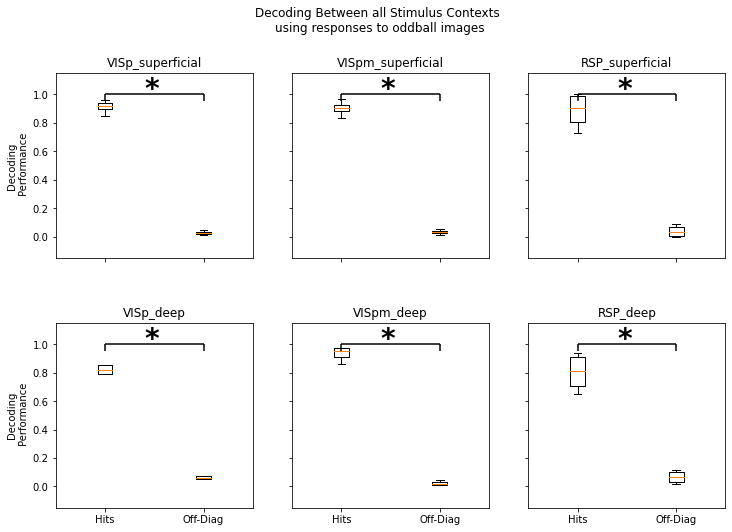

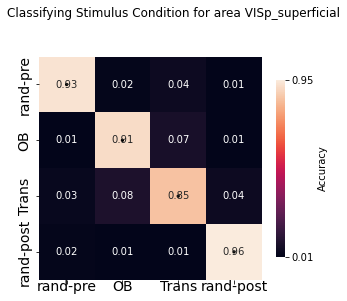

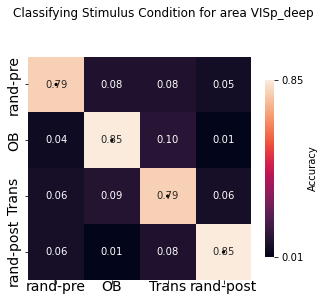

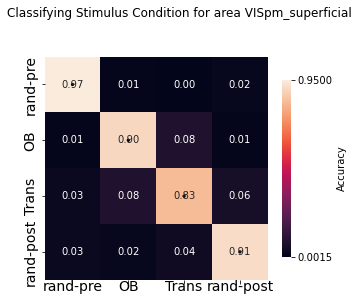

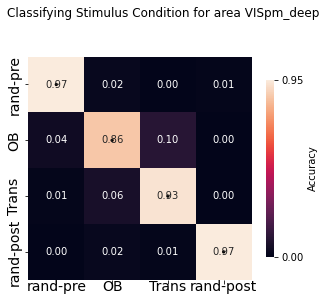

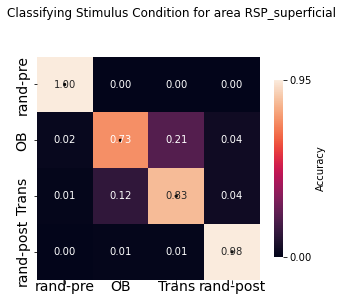

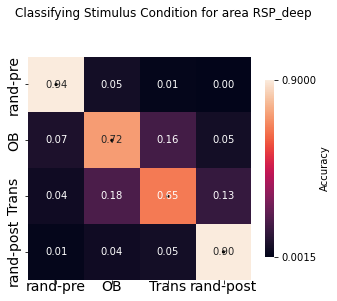

In [12]:
#Let's decode stimulus blocks from each other based on responses to oddball images

method='kfold'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation/PCA'
    fstr = 'PCA_pseudopop'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')
    fstr = 'pseudopop'

    
fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
for ii, area in enumerate(areanames):
    cell_ids = pseudopop_responses['oddball'][area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(locstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get data for this area
        X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(pseudopop_responses['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='X')
        X_oddball, Y_oddball, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')
        X_transctrl, Y_transctrl, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')
        X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(pseudopop_responses['randomized_control_post'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='X')
        
        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        
    
        indy_list = []; indy_list2 = []; indy_list3 = []
        for iImg, img_ID in enumerate(oddball_ids):
            tmp = np.where(Y_randctrl_pre == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list.append(tmp[:10])
            
            tmp = np.where(Y_randctrl_post == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list2.append(tmp[:10])
            
            tmp = np.where(Y_transctrl == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list3.append(tmp[:10])
            
        indy_randctrlpre = np.concatenate(indy_list)
        indy_randctrlpost = np.concatenate(indy_list2)
        indy_transctrl = np.concatenate(indy_list3)

        #Construct X and Y from both blocks
        X = np.vstack((X_randctrl_pre[indy_randctrlpre,:],X_oddball,X_transctrl[indy_transctrl,:],X_randctrl_post[indy_randctrlpost,:]))
        Y = np.hstack([np.repeat(i,100) for i in range(nClasses)])
        
        Y_sort = np.concatenate((['{}_0'.format(int(Y_randctrl_pre[ii])) for ii in indy_randctrlpre],['{}_1'.format(int(yy)) for yy in Y_oddball],['{}_2'.format(int(Y_transctrl[ii])) for ii in indy_transctrl],['{}_3'.format(int(Y_randctrl_post[ii])) for ii in indy_randctrlpost]))

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X)
            nComponents_pca = X_pca.shape[-1]
            print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
        else:
            confusion_mat, confusion_shf, confusion_z, _ = dc.cross_validate(X,Y,Y_sort,clabels=[0,1,2,3],classifier=classifier,nKfold=10,method=method,plot_shuffle=False,parallel=False)

        fpath = os.path.join(SaveDir,'StimulusBlocks_Ximgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['rand-pre','OB', 'Trans','rand-post'])
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'StimulusBlocks_usingoddballs_{}_{}_{}_{}.png'.format(fstr,locstr,method,classifier)))
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.diag(confusion_mat)
            
        offdiag_hits = []
        cm = confusion_mat.copy()
        cm[np.diag_indices(nClasses)] = np.nan
        offdiag_hits.extend([np.nanmean(cm[i,:]) for i in range(nClasses)]);

        _, pval = st.wilcoxon(diag_hits,offdiag_hits)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
        ax.boxplot([diag_hits,offdiag_hits])
#         if pval < pval_thresh:
        ax.hlines(1,*[1,2],color='k',zorder=0)
        ax.vlines(2,*[1,.95],color='k',zorder=0) 
        ax.vlines(1,*[1,.95],color='k',zorder=0)
        ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])
        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')
            
#         plt.show()
#         pdb.set_trace()
            
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to oddball images',y=0.995)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_usingoddballs_{}_{}_{}.png'.format(fstr,method,classifier)))

## Pairwise decoders of stimulus context

In [ ]:
#Let's decode MS images from the randomized ctrl pre vs post context

method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation/PCA'
    fstr = 'PCA_pseudopop'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')
    fstr = 'pseudopop'

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
for ii, area in enumerate(areanames):
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

    #         fig, axes = plt.subplots(1,2,figsize=(10,5))
        #Get data for this area
        X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pseudopop_responses[area][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
        X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pseudopop_responses[area][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')

        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        nNeurons = X_randctrl_pre.shape[-1]
        for iImg, img_ID in enumerate(mainseq_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_pre = np.where(Y_randctrl_pre == img_ID)[0]
            indy_post = np.where(Y_randctrl_post == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_randctrl_pre[indy_pre,:],X_randctrl_post[indy_post,:]))
            Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)

    #                 pdb.set_trace()
        fpath = os.path.join(SaveDir,'RandomizedCtrl_PreVsPost_MSimgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),class_labels=['Pre','Post'])

        plt.suptitle('Classifying RandCtrl Pre vs Post\nStimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrl_PreVsPost_avg-over-ms_{}_{}_{}.png'.format(locstr,method,classifier)))

        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(confusion_mat[i]) for i in range(len(mainseq_ids))])
        offdiag_hits = np.concatenate([confusion_mat[i][off_diagonal_indy] for i in range(len(mainseq_ids))])
        
        axes2[jj,ii].set_title(locstr)
        axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance')
            
#         plt.show()
#         pdb.set_trace()
            
fig2.suptitle('Decoding between RandCtrl Pre vs Post\ Contexts \nusing responses to oddball images',y=0.995)
fig2.savefig(os.path.join(PlotDir,'RandomizedCtrl_PreVsPost_BOXPLOT_avg-over-ms_{}_{}_{}.png'.format(fstr,method,classifier)))

In [ ]:
#Let's decode MS images from the oddball context, vs the transition ctrl context
method='L1O'

nClasses = 2
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))



reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation/PCA'
    fstr = 'PCA_pseudopop'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')
    fstr = 'pseudopop'

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
for ii, area in enumerate(areanames):
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
    
        #Get trials where MS images were presented from the randomized_ctrl block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))

        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        for iImg, img_ID in enumerate(mainseq_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_transctrl = np.where(Y_transctrl == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:]))
            Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))
            
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))
                
                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)
            
            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)
                
        fpath = os.path.join(SaveDir,'TransitionCtrlVsOddballBlocks_MSimgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        title = 'Classifying stimulus condition: Sequence vs Transition Control for {}'.format(locstr)
        dc.plot_confusion_matrices(confusion_mat, confusion_z, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['Sequence','Trans-Control'],title=title)
        plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_{}_{}_{}_{}.png'.format(fstr,locstr,method,classifier)))
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(confusion_mat[i]) for i in range(len(mainseq_ids))])
        offdiag_hits = np.concatenate([confusion_mat[i][off_diagonal_indy] for i in range(len(mainseq_ids))])
        
        axes2[jj,ii].set_title(locstr)
        axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance')
            
#         plt.show()
#         pdb.set_trace()
            
fig2.suptitle('Decoding between Sequence vs Transition Control Contexts \nusing responses to oddball images',y=0.995)
fig2.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks__BOXPLOT_avg-over-ms_{}_{}_{}.png'.format(fstr,method,classifier)))

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context

method='L1O'

nClasses = 2
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))



reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation/PCA'
    fstr = 'PCA_pseudopop'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')
    fstr = 'pseudopop'

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)
            #Get data for this area
            X_randctrl_all = randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth]
            X_oddball_all = oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth]

            #Get trials where MS images were presented from the randomized_ctrl block
            X_randctrl, Y_randctrl, _ = dc.match_trials(X_randctrl_all, stimulus_df, block=block_str, trial_type='ABCD')

            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(X_oddball_all, stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))
            pdb.set_trace()
            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))

            nNeurons = X_randctrl.shape[-1]
            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_randctrl = np.where(Y_randctrl == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_oddball[indy_oddball,:],X_randctrl[indy_randctrl,:]))
                Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))
                
                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))
            
                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],nKfold=5,classifier=classifier,method=method,plot_shuffle=False,parallel=False)

#                 pdb.set_trace()
            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_MSimgs_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            title = 'Sequence vs RandCtrl-{}'.format(pstr)
            dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Sequence','Rand-Ctrl'],title=title)
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.925)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsOddballBlocks_avg-over-ms_{}_{}_{}.png'.format(locstr,method,classifier)))

## What if we compare transition control with randomized control?
Give we can decode the oddball context from both the randomized control and transition control, we might expect the 2 to be indistiguishable...
But that's not what we find!

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'LDA'
method='L1O'

nClasses = 2

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ccontrol block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='ABCD')

            #Get trials where MS images were presented from the transition_control block
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')

            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))

            nNeurons = X_randctrl.shape[-1]
            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]
                indy_randctrl = np.where(Y_randctrl == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_transctrl[indy_transctrl,:],X_randctrl[indy_randctrl,:]))
                Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))
                
                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    #                     print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsTransitionCtrl_MSimgs_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            title = 'Classifying stimulus condition: TransCtrl vs RandCtrl-{} for {}'.format(pstr,locstr)
            dc.plot_confusion_matrices(confusion_mat, confusion_z, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['TransCtrl','RandCtrl'],title=title)
            plt.savefig(os.path.join(PlotDir,'RandomizedCtrl-{}VsTransitionCtrl_{}_{}.png'.format(pstr,locstr,method,classifier)))


## Let's use the oddball images to see if we decode context
Again, let's start with oddball vs randomized control

In [ ]:
# Let's decode stimulus context per oddball image; i.e. gather trials where an oddball image was presented from both conditions and decode stimulus context that way;
# We will have 10 confusion matrices which we will average over
# The problem with this is that each oddball is only presented 10 times in the oddball block, hence why we are doing leave-1-out x-validation
classifier = 'LDA'
method='L1O'

nClasses = 2

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ctrl block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')

            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X',trial_indy=slice(740,860))

            confusion_mat = np.zeros((len(oddball_ids),2,2))
            confusion_shf = np.zeros((len(oddball_ids),2,2))
            confusion_z = np.zeros((len(oddball_ids),2,2))

            for iImg, img_ID in enumerate(oddball_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_randctrl = np.where(Y_randctrl == img_ID)[0]
                np.random.shuffle(indy_randctrl)

                #Construct X and Y from both blocks
                X = np.vstack((X_oddball[indy_oddball,:],X_randctrl[indy_randctrl[:10],:]))
                Y = np.hstack((np.repeat(0,10),np.repeat(1,10)))

                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    #                     print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_OBimgs_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            title = 'Sequence vs RandCtrl-{}'.format(pstr)
            dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Sequence','Randomized Ctrl'],title=title)
        plt.suptitle('Classifying Stimulus Condition for {} using\n each Oddball Image separately'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsOddballBlocks_avg-over-oddballs_{}_{}_{}.png'.format(locstr,method,classifier)))

In [ ]:
#Let's do the same thing, but combine all the trials where an oddball was presented and use those to decode stimulus context;
#This way we have more trials for each stimulus context
method='kfold'
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ctrl block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')

            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')

            indy_list = []
            for iImg, img_ID in enumerate(oddball_ids):
                tmp = np.where(Y_randctrl == img_ID)[0]
                np.random.shuffle(tmp)
                indy_list.append(tmp[:10])

            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_randctrl = np.concatenate(indy_list)

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball,X_randctrl[indy_randctrl,:]))
            Y = np.hstack((np.repeat(0,len(Y_oddball)),np.repeat(1,len(indy_randctrl))))

            #Create this vector so that the cross validation conserves the proportion of trials for each oddball image in the training and test sets
            Y_sort = np.concatenate((['{}_0'.format(int(yy)) for yy in Y_oddball],['{}_1'.format(int(Y_randctrl[i])) for i in indy_randctrl]))
#             pdb.set_trace()
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)

            else:
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)
                    

            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_OBimgTogether_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            title = 'Sequence vs RandCtrl-{}'.format(pstr)
            dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['Sequence','Rand-Ctrl'],title=title)
        plt.suptitle('Classifying Stimulus Condition for {}\n using all Oddball Images together'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsOddballBlocks_all-oddballs_{}_{}_{}.png'.format(locstr,method,classifier)))

## What about oddball vs transition control?
again using the oddball images separately, then averaging over them

In [ ]:
classifier = 'nearest_neighbor'
method='L1O'
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where odbball images were presented from the transition_control block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

        #Get trials where odbball images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')

        confusion_mat = np.zeros((len(oddball_ids),2,2))
        confusion_shf = np.zeros((len(oddball_ids),2,2))
        confusion_z = np.zeros((len(oddball_ids),2,2))

        for iImg, img_ID in enumerate(oddball_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_transctrl = np.where(Y_transctrl == img_ID)[0]
            np.random.shuffle(indy_transctrl)

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball[indy_oddball,:],X_transctrl[indy_transctrl[:10],:]))
            Y = np.hstack((np.repeat(0,10),np.repeat(1,10)))

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_OBimgs_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),class_labels=['Sequence','Trans-Ctrl'],title=title)
        plt.suptitle('Classifying Stimulus Condition\n using all Oddball Images; {}'.format(locstr),y=0.975)
        plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_avg-over-oddballs_{}_{}_{}.png'.format(locstr,method,classifier)))

In [ ]:
#For completeness sakes, let's do the same thing, but combine all the trials where an oddball was presented and use those to decode stimulus context;
#This way we have more trials for each stimulus context
classifier = 'SVM'
method='kfold'
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where odbball images were presented from the transition_control block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')

        #Since the transition control block has more than 10 trials per oddball image, we have to take 10 randomly
        indy_list = []
        for img_ID in oddball_ids:
            tmp = np.where(Y_transctrl == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list.append(tmp[:10])

        indy_transctrl = np.concatenate(indy_list)

        #Construct X and Y from both blocks
        X = np.vstack((X_oddball,X_transctrl[indy_transctrl,:]))
        Y = np.hstack((np.repeat(0,len(Y_oddball)),np.repeat(1,len(indy_transctrl))))

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

        else:
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)
               

        fpath = os.path.join(SaveDir,'TransitionCtrlVsOddballBlocks_OBimgTogether_{}_{}.mat'.format(locstr,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['Sequence','Transition Ctrl'])
        plt.suptitle('Classifying Stimulus Condition for {}\n using all Oddball Images together'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_all-oddballs_{}_{}.png'.format(locstr,classifier)))

## What about transition control vs randomized control?
using the oddball images 

In [ ]:
classifier = 'nearest_neighbor'
method='L1O'
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ccontrol block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')

            #Get trials where MS images were presented from the transition_control block
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

            confusion_mat = np.zeros((len(oddball_ids),2,2))
            confusion_shf = np.zeros((len(oddball_ids),2,2))
            confusion_z = np.zeros((len(oddball_ids),2,2))

            for iImg, img_ID in enumerate(oddball_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]
                indy_randctrl = np.where(Y_randctrl == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_transctrl[indy_transctrl,:],X_randctrl[indy_randctrl,:]))
                Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsTransitionCtrl_MSimgs_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            title = 'TransCtrl vs RandCtrl-{}'.format(pstr)
            dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Transition Ctrl','Randomized Ctrl'],title=title)

        plt.suptitle('Classifying Stimulus Condition for area {} using oddball images'.format(locstr),y=0.925)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsTransitionCtrl_avg-over-oddballs_{}_{}_{}.png'.format(locstr,method,classifier)))

## Let's try to decode trials in which image A followed image D vs an oddball
i.e. DA vs XA transitions in the transition control

In [ ]:
#In the transition control, there are 30 trials per transition type. so, there are 30 trials where DA are presented in series and 30 trials where DX are presented per oddball
#So, given the # of trials per transition type, I created a decoder for each XA type, keeping the DA trials the same
method='L1O'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')


nClasses = 2
for area in areanames:
    cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where A images were presented from the transition_control block
        X_transctrl, Y_transctrl, Y_sort = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='DAXA')

        confusion_mat = np.zeros((len(oddball_ids),2,2))
        confusion_shf = np.zeros((len(oddball_ids),2,2))
        confusion_z = np.zeros((len(oddball_ids),2,2))

        for iImg, img_ID in enumerate(oddball_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_DA = np.where(Y_sort == mainseq_ids[0])[0]
            indy_XA = np.where(Y_sort == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_transctrl[indy_DA,:],X_transctrl[indy_XA,:]))
            Y = np.hstack((np.repeat(0,len(indy_DA)),np.repeat(1,len(indy_XA))))

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'DAvsXA_TransCtrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),class_labels=['(D,A)','(X,A)'])

        plt.suptitle('Classifying Transition Type\n Based on image A response; {}'.format(locstr),y=0.925)
        plt.savefig(os.path.join(PlotDir,'DAvsXA_TransCtrl-block_{}_{}_{}.png'.format(locstr,method,classifier)))

## What about in the oddball block: (X,A) vs (D,A)

In [ ]:
#In the transition control, there are 30 trials per transition type. so, there are 30 trials where DA are presented in series and 30 trials where DX are presented per oddball
#So, given the # of trials per transition type, I created a decoder for each XA type, keeping the DA trials the same
method='kfold'; classifier = 'SVM'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    cell_ids = pseudopop_responses['oddball'][area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where A images were presented from the transition_control block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='DAXA')
#         pdb.set_trace()
#         #Perform cross-validated decoding analysis
#         confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=[0,1],classifier=classifier,method=method)
        
        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,clabels=[0,1],classifier=classifier,method=method)

        else:
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=[0,1],classifier=classifier,method=method)
                
        fpath = os.path.join(SaveDir,'DAvsXA_Oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['(D,A)','(X,A)'])
        plt.suptitle('Classifying Transition Type in oddball block\n Based on image A response; {}'.format(locstr),y=0.925)
        # plt.show()
        # pdb.set_trace()
        plt.savefig(os.path.join(PlotDir,'DAvsXA_Oddball-block_{}_{}_{}.png'.format(locstr,method,classifier)))

In [ ]:
method='kfold'; classifier = 'SVM'
fig, axes = plt.subplots(1,2,figsize=(6,3),gridspec_kw={'hspace':0.25,'wspace':0.25},sharey=True,sharex=True)
for ii, area in enumerate(['VISp','RSP']):
    depthstr = 'superficial'

    locstr = '{}_{}'.format(area,depthstr)

    fpath = os.path.join(SaveDir,'DAvsXA_Oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
    with h5py.File(fpath,'r') as h5file:
        confusion_mat = np.array(h5file['confusion_mat'])
        confusion_shf = np.array(h5file['confusion_shf'])
        confusion_z = np.array(h5file['confusion_z'])


        #Plot shuffle distributions
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],clims=[0,1],class_labels=['(D,A)','(X,A)'])

        
#         plt.suptitle('Classifying Transition Type in oddball block\n Based on image A response; {}'.format(locstr),y=0.925)
        # plt.show()

plt.savefig(os.path.join('./plots/paper','XAvsDA_3x6_decoding_oddball-blocks_{}_{}.pdf'.format(method,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

## Image Identity
Let's see if we can decode image identity in the randomized blocks using the pseudopopulation 

In [ ]:
classifier = 'QDA'; method='L1O'
reduce_dim=False

#Get off diagonal indices
nClasses = len(mainseq_ids)
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))
reduce_dim = False
if reduce_dim:
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation/PCA'
    fstr = 'PCA_pseudopop'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopop_meanresp'
    fstr = 'pseudopop'
    PlotDir = os.path.join(SaveDir,'plots')
    
classifier = 'NeuralNet'
#     for pp, pstr in enumerate(['pre','post']): 
        
pstr = 'pre'
block_str = 'randomized_control_{}'.format(pstr)

#         fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#         for ii, area in enumerate(areanames):
area = 'RSP'
cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values

#             for jj,depthstr in enumerate(['superficial','deep']):
depthstr = 'superficial'
locstr = '{}_{}'.format(area,depthstr)
cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

#Get trials where MS images were presented from the randomized_ctrl block
X_randctrl, Y_randctrl, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')

if reduce_dim:
    #Reduce dimensionality using PCA
    pca = PCA(n_components=0.99)
    X_pca = pca.fit_transform(X_randctrl)
    nComponents_pca = X_pca.shape[-1]
#     pdb.set_trace()

    #Perform cross-validated decoding analysis
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_randctrl,clabels=mainseq_ids,shuffle=False,classifier=classifier,method=method)

else:
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_randctrl,Y_randctrl,clabels=mainseq_ids,classifier=classifier,method=method,shuffle=False,parallel=True,nProcesses=50)

#             fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
#             with h5py.File(fpath,'w') as h5file:
#                 h5file.create_dataset('confusion_mat',data=confusion_mat)
#                 h5file.create_dataset('confusion_shf',data=confusion_shf)
#                 h5file.create_dataset('confusion_z',data=confusion_z)
#                 h5file.create_dataset('area',data=area)
#                 h5file.create_dataset('classifier',data=classifier)
#                 h5file.create_dataset('method',data=method)

dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['A','B','C','D'])#,clims=[0.1,0.4])

plt.suptitle('Classifying MS images for {}'.format(locstr),y=0.925,fontsize=14)
# plt.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-blocks_{}_{}.pdf'.format(locstr,classifier)))

#          #Sparate diagonal and off-diagonal performance
#         diag_hits = np.diag(confusion_mat)
#         offdiag_hits = confusion_mat[off_diagonal_indy]

#         axes2[jj,ii].set_title(locstr)
#         axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
#         if jj == 1:
#             axes2[jj,ii].set_xticks([1,2])
#             axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
#         if ii == 0:
#             axes2[jj,ii].set_ylabel('Decoding Performance')

#         fig2.suptitle('Classifying MS images for {}, {} classifer'.format(locstr,classifier),y=0.995)
#         fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-blocks_{}_{}.png'.format(method,classifier)))


In [ ]:
classifier = 'SVM'; method='kfold'
reduce_dim=False

#Get off diagonal indices
nClasses = len(mainseq_ids)
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))
reduce_dim = False
if reduce_dim:
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation/PCA'
    fstr = 'PCA_pseudopop'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopop_meanresp'
    fstr = 'pseudopop'
    PlotDir = os.path.join(SaveDir,'plots')
    
for pp, pstr in enumerate(['pre','post']): 
    block_str = 'randomized_control_{}'.format(pstr)

    fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
    for ii, area in enumerate(areanames):
        cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values

        for jj,depthstr in enumerate(['superficial','deep']):
            locstr = '{}_{}'.format(area,depthstr)
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

            #Get trials where MS images were presented from the randomized_ctrl block
            X_randctrl, Y_randctrl, _ = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='ABCD')

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X_randctrl)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_randctrl,clabels=mainseq_ids,classifier=classifier,method=method)

            else:
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_randctrl,Y_randctrl,clabels=mainseq_ids,classifier=classifier,method=method,shuffle=True,parallel=True,nProcesses=50)

            fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['A','B','C','D'])#,clims=[0.1,0.4])

            plt.suptitle('Classifying MS images for {}'.format(locstr),y=0.925,fontsize=14)
            plt.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-blocks_{}_{}.pdf'.format(locstr,classifier)))

             #Sparate diagonal and off-diagonal performance
            diag_hits = np.diag(confusion_mat)
            offdiag_hits = confusion_mat[off_diagonal_indy]

            axes2[jj,ii].set_title(locstr)
            axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
            if jj == 1:
                axes2[jj,ii].set_xticks([1,2])
                axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
            if ii == 0:
                axes2[jj,ii].set_ylabel('Decoding Performance')

            fig2.suptitle('Classifying MS images for {}, {} classifer'.format(locstr,classifier),y=0.995)
            fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-blocks_{}_{}.png'.format(method,classifier)))


In [ ]:
classifier = 'SVM'; method='kfold'
reduce_dim=False

#Get off diagonal indices
nClasses = len(mainseq_ids)
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))
reduce_dim = False
if reduce_dim:
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation/PCA'
    fstr = 'PCA_pseudopop'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopop_meanresp'
    fstr = 'pseudopop'
    PlotDir = os.path.join(SaveDir,'plots')
    


fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
for ii, area in enumerate(areanames):
    cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values

    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

        #Get trials where MS images were presented from the randomized_ctrl block
        X0, Y0, _ = dc.match_trials(pseudopop_deconv['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
        X1, Y1, _ = dc.match_trials(pseudopop_deconv['randomized_control_post'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')

        X = np.vstack((X0,X1))
        Y = np.hstack((Y0,Y1))

        Y_sort0 = [f'{int(y)}_0' for y in Y0]
        Y_sort1 = [f'{int(y)}_1' for y in Y1]
        Y_sort = np.hstack((Y_sort0,Y_sort1))

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method)

        else:
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,shuffle=True,parallel=False,nProcesses=50)

#             fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
#             with h5py.File(fpath,'w') as h5file:
#                 h5file.create_dataset('confusion_mat',data=confusion_mat)
#                 h5file.create_dataset('confusion_shf',data=confusion_shf)
#                 h5file.create_dataset('confusion_z',data=confusion_z)
#                 h5file.create_dataset('area',data=area)
#                 h5file.create_dataset('classifier',data=classifier)
#                 h5file.create_dataset('method',data=method)

        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['A','B','C','D'])#,clims=[0.1,0.4])

        plt.suptitle('Classifying MS images for {}'.format(locstr),y=0.925,fontsize=14)
        plt.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-blocks_{}_{}.pdf'.format(locstr,classifier)))

         #Sparate diagonal and off-diagonal performance
        diag_hits = np.diag(confusion_mat)
        offdiag_hits = confusion_mat[off_diagonal_indy]

        axes2[jj,ii].set_title(locstr)
        axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance')

fig2.suptitle('Classifying MS images for {}, {} classifer'.format(locstr,classifier),y=0.995)
fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-blocks_{}_{}.png'.format(method,classifier)))


## Let's see if we can decode image identity in the transition control block
using the second images of the (D,A),(A,B),(B,C),(C,D) transitions 

In [ ]:
reduce_dim=False
classifier = 'nearest_neighbor'
    
block_str = 'transition_control'
classifier = 'SVM'; method = 'L1O'
#Loop over depth as well
for jj, depthstr in enumerate(['superficial','deep']):

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where MS images were presented from the transition control block
        X_transctrl, Y_transctrl, _ = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
#         print(np.unique(Y_transctrl,return_counts=True))
#         pdb.set_trace()
        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_transctrl)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_transctrl,clabels=mainseq_ids,classifier=classifier,method=method)

        else:
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_transctrl,Y_transctrl,clabels=mainseq_ids,classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'mainseq_decoding_transition-ctrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=locstr,annot=True)
    plt.suptitle('Classifying MS Images\n in transition control block, {} classifier'.format(classifier))
    plt.savefig(os.path.join(PlotDir,'mainseq_decoding_transition-ctrl-block_{}-areas_{}_{}.png'.format(depthstr,method,classifier)))

## Can we decode image identity in the oddball block?
Let's use the first 240 trials, then 240 trials in the middle, then the last 240 trials

In [ ]:
method='kfold'

reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons/drift'
    PlotDir = os.path.join(SaveDir,'plots')
    
# slice_list = [slice(0,2000),slice(3000,5000),slice(6160,6400)]
# slice_str = ['first2000','middle2000','last240']
# sl_val = slice_list[1]
# sl_str = slice_str[1]

nClasses = 4
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

diag_hits_list = []
offdiag_hits_list = []
for iStart in range(0,6401,200):
    iEnd = iStart + 200
    print('start-{:03d}'.format(iStart))
    
    sl_val = slice(iStart, iEnd)
    sl_str = 'start-{:03d}'.format(iStart)
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        fig, axes = plt.subplots(1,3,figsize=(15,5))
        for ii,area in enumerate(areanames):
            cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
            locstr = '{}_{}'.format(area,depthstr)
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)


            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=sl_val)
    #         pdb.set_trace()
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X_oddball)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method)

            else:
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method,parallel=True)

             #Sparate diagonal and off-diagonal performance
            diag_hits_list.append(np.diag(confusion_mat))
            offdiag_hits_list.append(confusion_mat[off_diagonal_indy])

            fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=area,annot=True)
        plt.suptitle('Classifying MS Images for {} areas, Oddball block, {} classifier'.format(depthstr,classifier))
        plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_{}-areas_{}_{}_{}.png'.format(depthstr,sl_str,method,classifier)))

In [ ]:
method='kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopop_maxresp'
    PlotDir = os.path.join(SaveDir,'plots')
    
method='kfold' 
classifier = 'SVM'

slice_list = [slice(0,240),slice(3080,3320),slice(6160,6400)]
slice_str = ['first240','middle240','last240']

# slice_list = [slice(0,120),slice(3080,3200),slice(6280,6400)]
# slice_str = ['first120','middle120','last120']

block_str = 'oddball'
for area in areanames:
    cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,3,figsize=(15,5))
#         for ii,(sl_val,sl_str) in enumerate(zip(slice_list,slice_str)):
        ii = 1; sl_val = slice_list[ii]; sl_str = slice_str[ii]
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=sl_val)

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method)

        else:
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method,parallel=True,nProcesses=75)

#             fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
#             with h5py.File(fpath,'w') as h5file:
#                 h5file.create_dataset('confusion_mat',data=confusion_mat)
#                 h5file.create_dataset('confusion_shf',data=confusion_shf)
#                 h5file.create_dataset('confusion_z',data=confusion_z)
#                 h5file.create_dataset('area',data=area)
#                 h5file.create_dataset('classifier',data=classifier)
#                 h5file.create_dataset('method',data=method)


        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=sl_str,annot=True)
        plt.suptitle('Classifying MS Images for {}, Oddball block, {} classifier'.format(locstr,classifier))
#         plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_{}_{}_{}.png'.format(locstr,method,classifier)))

## Deterime how quickly temporal binding occurs

In [112]:
for iT in range(25):
    trial_slice = slice((iT+1)*240,(iT+2)*240)
    print(trial_slice)

slice(240, 480, None)
slice(480, 720, None)
slice(720, 960, None)
slice(960, 1200, None)
slice(1200, 1440, None)
slice(1440, 1680, None)
slice(1680, 1920, None)
slice(1920, 2160, None)
slice(2160, 2400, None)
slice(2400, 2640, None)
slice(2640, 2880, None)
slice(2880, 3120, None)
slice(3120, 3360, None)
slice(3360, 3600, None)
slice(3600, 3840, None)
slice(3840, 4080, None)
slice(4080, 4320, None)
slice(4320, 4560, None)
slice(4560, 4800, None)
slice(4800, 5040, None)
slice(5040, 5280, None)
slice(5280, 5520, None)
slice(5520, 5760, None)
slice(5760, 6000, None)
slice(6000, 6240, None)


In [20]:
areanames = ['VISp', 'VISpm','RSP']
nNeurons = 0
for area in areanames:
    nNeurons+=pseudopop_responses[block_str][area].shape[-1]

In [21]:
nNeurons

5998

In [14]:

classifier = 'SVM'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
PlotDir = os.path.join(SaveDir,'plots')
    
from sklearn import svm
from sklearn.metrics import confusion_matrix

block_str = 'oddball'
for area in areanames:
    cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where MS images for training set
        X_test, Y_test, _ = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(0,240))
        
        binding_rate_list = []
        for iT in range(25):
            trial_slice = slice((iT+1)*240,(iT+2)*240)
            X_train, Y_train, _ = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=trial_slice)
        
            #How many classes are we trying to classify?
            class_labels,nTrials_class = np.unique(Y_train,return_counts=True)
            nClasses = len(class_labels)

            #Construct classifier
            clf = svm.LinearSVC(max_iter=1E6) #penalty='l1',dual=False,

            #Fit model to the training data
            clf.fit(X_train, Y_train)
            nSets = 60
            binding_rate = []
            for iSet in range(nSets):
                trial_slice = slice(iSet*4,(iSet+1)*4)
                #Predict test data
                Y_hat = clf.predict(X_test[trial_slice])
                hits = np.sum(Y_test[trial_slice] == Y_hat)
                binding_rate.append(hits)
            binding_rate_list.append(binding_rate)
        pdb.set_trace()
        
# #         #Get weights
# #         decoding_weights = clf.coef_
    
#     #Calculate confusion matrix
#     kfold_hits = confusion_matrix(Y_test,Y_hat,labels=clabels)
        
#         for iTrain, (X_train,Y_train) in enumerate(zip(X_list,Y_list)):
#             for iTest, (X_test,Y_test) in enumerate(zip(X_list,Y_list)):
#                 if iTrain == iTest:
#                     continue
                    
#                 if parallel:
#                     processes.append(pool.apply_async(dc.decode_labels,args=(X_train,Y_train,None,None,classifier,mainseq_ids,X_test,Y_test)))
                    

#         #Get trials where MS images were presented from the middle of the oddball block
#         X_oddball, Y_oddball, _ = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=sl_val)


#         confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method,parallel=True,nProcesses=75)

# #             fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
# #             with h5py.File(fpath,'w') as h5file:
# #                 h5file.create_dataset('confusion_mat',data=confusion_mat)
# #                 h5file.create_dataset('confusion_shf',data=confusion_shf)
# #                 h5file.create_dataset('confusion_z',data=confusion_z)
# #                 h5file.create_dataset('area',data=area)
# #                 h5file.create_dataset('classifier',data=classifier)
# #                 h5file.create_dataset('method',data=method)


#         dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=sl_str,annot=True)
#         plt.suptitle('Classifying MS Images for {}, Oddball block, {} classifier'.format(locstr,classifier))
# #         plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_{}_{}_{}.png'.format(locstr,method,classifier)))

> <ipython-input-14-57e24948a22c>(13)<module>()
     11 
     12     #Loop over depth as well
---> 13     for depthstr in ['superficial','deep']:
     14         locstr = '{}_{}'.format(area,depthstr)
     15         cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values



ipdb>  q


BdbQuit: 

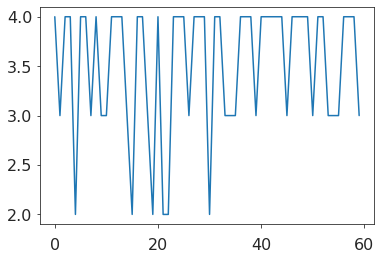

In [17]:
plt.plot(binding_rate_list[0])

In [117]:
np.mean(binding_rate_list,axis=0).shape

(60,)

## Decoding performance as a function of # of neurons in pseudopopulation

In [ ]:
#This takes a while to run
method='kfold'

classifier = 'SVM'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 4
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


slice_list = [slice(0,240),slice(3080,3320),slice(6160,6400)]
slice_str = ['first240','middle240','last240']

diag_hits_list = []
offdiag_hits_list = []
for ii,area in enumerate(areanames):
    #Loop over depth as well
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids = pseudopop_responses['oddball'][area].coords['cell_specimen_id'].values
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        nNeurons = len(cell_ids_perdepth)
        nNeurons_subselect = np.arange(nNeurons,0,-50)
        if nNeurons_subselect[-1] < 50:
            nNeurons_subselect = nNeurons_subselect[:-1]
        
        nRepeats = 20
#         pdb.set_trace()
         #Extract results from parallel kfold processing
        pool = mp.Pool(processes=40)
        processes = []
        for nN in tqdm(nNeurons_subselect):
            
            tmp_list = []
            for iR in range(nRepeats):
                cell_ids_sub = np.random.choice(cell_ids_perdepth,nN,replace=False)
        
                #Get trials where MS images were presented from the middle of the oddball block
                X_oddball, Y_oddball, Y_sort = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_sub], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(3080,3320))

                #Perform cross-validated decoding analysis
                tmp_list.append(pool.apply_async(dc.cross_validate,args=(X_oddball,Y_oddball), kwds={'Y_sort':Y_sort, 'clabels':mainseq_ids, 'classifier':classifier, 'method':method,}))
            processes.append(tmp_list)
                
            
        confusion_mat = np.zeros((len(nNeurons_subselect),nRepeats,4,4))
        confusion_shf = np.zeros((len(nNeurons_subselect),nRepeats,4,4))
        confusion_z = np.zeros((len(nNeurons_subselect),nRepeats,4,4))
        if parallel:
            for i, tmp_list in enumerate(processes):
                for j, p in enumerate(tmp_list):
                    confusion_mat[i,j] = p.get()[0]
                    confusion_shf[i,j] = p.get()[1]
                    confusion_z[i,j] = p.get()[2]
            pool.close()

        fpath = os.path.join(SaveDir,'mainseq_decoding_nNeuron-dependence_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('nNeurons_subselect',data=nNeurons_subselect)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
#         pdb.set_trace()


In [ ]:
ls_list = ['-','--']
ms_list = ['o','x']
ms_list= ['o','x']; ms_list2 = ['d','+']
fig, axes = plt.subplots(1,3,figsize=(15,5))
fig.suptitle('Dependence of neural population size on decoding performance',y=1.05,fontsize=25)

for ii,area in enumerate(areanames):
    ax = axes[ii]; ax.set_title(area)
    #Loop over depth as well
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        
        SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
        method = 'kfold'; classifier = 'SVM'
        fpath = os.path.join(SaveDir,'mainseq_decoding_nNeuron-dependence_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
            nNeurons_subselect = np.array(h5file['nNeurons_subselect'])
            
        tmp_list = []
        for i in range(len(mainseq_ids)):
            tmp = confusion_mat[:,:,i,i]; tmp_list.append(tmp)
            
        #average over main sequence images
        tmp = np.mean(tmp_list,axis=0)
        ax.errorbar(x=nNeurons_subselect,y=np.mean(tmp,axis=1),yerr=np.std(tmp,axis=1),color=cc[ii+5],marker='.',ls=ls_list[jj],label=f'{depthstr} pseudopopulation',lw=2)
        
        
        fpath = os.path.join('/home/dwyrick/projects/predictive_coding/results/decoding/persession','mainseq_decoding_oddball-block_{}_middle-epoch_kfold_SVM.mat'.format(locstr))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat_list =  np.array(h5file['confusion_mat_list'])
            confusion_shf_list =  np.array(h5file['confusion_shf_list'])
            confusion_z_list =  np.array(h5file['confusion_z_list'])
            nNeurons_list =  np.array(h5file['nNeurons_list'])
            eID_list =  np.array(h5file['eID_list'])
            
        indy = np.argsort(nNeurons_list);
        nNeurons_list = np.array(nNeurons_list)
        nNeurons_list = nNeurons_list[indy]
        mean_decoding_performance = np.array([np.mean(np.diag(cm)) for cm in confusion_mat_list])
        mean_decoding_performance = mean_decoding_performance[indy]
        ax.scatter(nNeurons_list,mean_decoding_performance,color='k',marker=ms_list2[jj],label=f'{depthstr} session',zorder=3,s=75)
        
    if ii == 1:
        ax.set_xlabel('# of neurons in pseudopopulation',fontsize=22)
    if ii == 0:
        ax.set_ylabel('Decoding derformace',fontsize=22)
    ax.set_ylim([0.2,1])#ax.set_xlim([0,400])
    ax.set_yticks([0.2,0.6,1])
#     ax.legend()

# plt.savefig('./plots/paper/NeuronDependence_pseudpop_MainseqDecoding-oddballblock.pdf')
        
        
        

In [ ]:
ls_list = ['-',':']
ms_list = ['o','x']
ms_list= ['d','.']; ms_list2 = ['d','+']
fig, ax = plt.subplots(figsize=(4,4))
# fig.suptitle('Dependence of neural population size on decoding performance',y=1.05,fontsize=25)

for ii,area in enumerate(areanames):
#     ax = axes[ii]; ax.set_title(area)
    #Loop over depth as well
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        
        SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
        method = 'kfold'; classifier = 'SVM'
        fpath = os.path.join(SaveDir,'mainseq_decoding_nNeuron-dependence_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
            nNeurons_subselect = np.array(h5file['nNeurons_subselect'])
            
        tmp_list = []
        for i in range(len(mainseq_ids)):
            tmp = confusion_mat[:,:,i,i]; tmp_list.append(tmp)
            
        #average over main sequence images
        tmp = np.mean(tmp_list,axis=0)
        ax.errorbar(x=nNeurons_subselect,y=np.mean(tmp,axis=1),yerr=np.std(tmp,axis=1),color=cc[ii+5],marker='.',ls=ls_list[jj],label=f'{depthstr} pseudopopulation',lw=2)
        
        
        fpath = os.path.join('/home/dwyrick/projects/predictive_coding/results/decoding/persession','mainseq_decoding_oddball-block_{}_middle-epoch_kfold_SVM.mat'.format(locstr))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat_list =  np.array(h5file['confusion_mat_list'])
            confusion_shf_list =  np.array(h5file['confusion_shf_list'])
            confusion_z_list =  np.array(h5file['confusion_z_list'])
            nNeurons_list =  np.array(h5file['nNeurons_list'])
            eID_list =  np.array(h5file['eID_list'])
            
        indy = np.argsort(nNeurons_list);
        nNeurons_list = np.array(nNeurons_list)
        nNeurons_list = nNeurons_list[indy]
        mean_decoding_performance = np.array([np.mean(np.diag(cm)) for cm in confusion_mat_list])
        mean_decoding_performance = mean_decoding_performance[indy]
        ax.scatter(nNeurons_list,mean_decoding_performance,marker=ms_list[jj],color=cc[ii+5],edgecolors='k',label=f'{depthstr} session',zorder=3,s=75)
        
    if ii == 1:
        ax.set_xlabel('# of neurons\n in pseudopopulation',fontsize=22)
    if ii == 0:
        ax.set_ylabel('Decoding\n performance',fontsize=22)
    ax.set_ylim([0.2,1])#ax.set_xlim([0,400])
    ax.set_yticks([0.2,0.6,1])
#     ax.legend()

# plt.savefig('./plots/paper/NeuronDependence_pseudpop_MainseqDecoding-oddballblock.pdf')
        
from matplotlib.lines import Line2D
legend_elements = []
for ii, area in enumerate(arealabels):
    legend_elements.append(Line2D([0], [0], color=cc[ii+5], lw=2,label=area))

legend_elements.append(Line2D([0], [0], color='k', marker=ms_list[0],lw=0,ls='-',label='superficial'))
legend_elements.append(Line2D([0], [0], color='k',marker=ms_list[1], lw=0,ls=':',label='deep'))
        
# ax.legend(handles=legend_elements, loc='center')
plt.savefig('./plots/paper/NeuronDependence_pseudpop_MainseqDecoding-oddballblock1.pdf', facecolor='white', transparent=True, bbox_inches='tight')

In [16]:
arealabels = ['V1','PM','RSP']
nEpochs = 3
for i in range(nEpochs):
    slindy = slice(i*3000+120,i*3000+240)
    print(slindy)

slice(120, 240, None)
slice(3120, 3240, None)
slice(6120, 6240, None)


## Decode Time

In [ ]:
method='kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')
    
method='kfold' 
classifier = 'SVM'

nEpochs = 3
block_str = 'oddball'
for area in areanames:
    cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,4,figsize=(20,5))
        
        X_list = []; Y_list = []; Y_sort_list = []        
        #Get trials where MS images are presented in the sequence context
        for i in range(nEpochs):
#             slindy = slice(i*1000,i*1000+120)
            slindy = slice(i*3000+120,i*3000+240)
            X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
            Y_sort = [f'{int(y)}_{i}' for y in Y]; Y_sort_list.append(Y_sort)
            X_list.append(X); Y_list.append(Y)
        X = np.concatenate(X_list); Y = np.concatenate(Y_list); Y_sort = np.concatenate(Y_sort_list)
        
        nClasses = nEpochs
        confusion_mat = np.zeros((len(mainseq_ids), nClasses, nClasses))
        confusion_shf = np.zeros((len(mainseq_ids), nClasses, nClasses))
        confusion_z = np.zeros((len(mainseq_ids), nClasses, nClasses))
        for ii, iID in enumerate(mainseq_ids):
            indy = np.where(Y == iID)
            X_sub = X[indy]; Y_sort_sub = [Y_sort[ii] for ii in indy]
            Y_sub = np.array(Y_sort_sub).reshape(-1,)
#             pdb.set_trace()

            confusion_mat[ii], confusion_shf[ii], confusion_z[ii] = dc.cross_validate(X_sub,Y_sub,clabels=np.unique(Y_sort_sub),classifier=classifier,method=method,parallel=True,nProcesses=75)

            dc.plot_decoding_accuracy(confusion_mat[ii],confusion_z[ii],ax=axes[ii],class_labels=['Early','Middle','Late'],title=mainseq_labels[ii],annot=False,clims=[0,1])
            axes[ii].set_xlabel('Test Epoch')
            axes[ii].set_ylabel('Training Epoch')

        plt.suptitle('Classifying Time within Sequence block using main-seq; {}, {} classifier'.format(locstr,classifier))
        plt.savefig(os.path.join('./plots/paper','time_decoding_oddball-block_3epochs_{}_{}_{}.pdf'.format(locstr,method,classifier)))
        
        fpath = os.path.join(SaveDir,'DecodeTimePseudoPop_usingMSimgs_3epochs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        fig, ax = plt.subplots(figsize=(6,6))
        dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=ax,class_labels=np.arange(3),annot=False,clims=[0,1])
        ax.set_xlabel('Actual Epoch')
        ax.set_ylabel('Decoded Epoch')
        plt.savefig(os.path.join('./plots/paper','time_decoding_oddball-block_avg-over-mainseq_3epochs_{}_{}.pdf'.format(locstr,classifier)))
        
        

In [64]:

nEpochs = 16
for i in range(nEpochs):
    slindy = slice(i*420,i*420+120)
    print(slindy)

slice(0, 120, None)
slice(420, 540, None)
slice(840, 960, None)
slice(1260, 1380, None)
slice(1680, 1800, None)
slice(2100, 2220, None)
slice(2520, 2640, None)
slice(2940, 3060, None)
slice(3360, 3480, None)
slice(3780, 3900, None)
slice(4200, 4320, None)
slice(4620, 4740, None)
slice(5040, 5160, None)
slice(5460, 5580, None)
slice(5880, 6000, None)
slice(6300, 6420, None)


ValueError: operands could not be broadcast together with shapes (1278,16) (1278,) 

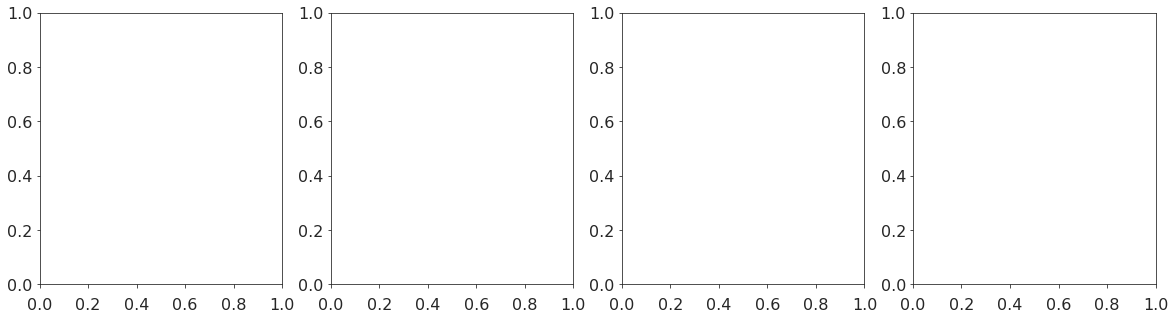

In [65]:
method='kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')
    
method='kfold' 
classifier = 'SVM'

nEpochs = 16
block_str = 'oddball'
for area in areanames:
    cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,4,figsize=(20,5))
        
        X_list = []; Y_list = []; Y_sort_list = []
        PSTH_list = [[] for ii in range(4)]
        #Get trials where MS images are presented in the sequence context
        for i in range(nEpochs):
            slindy = slice(i*420,i*420+120)
#             slindy = slice(i*1000,i*1000+120)
#             slindy = slice(i*3000+120,i*3000+240)
            X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
            for ii, iID in enumerate(mainseq_ids):
                indy = np.where(Y == iID)
                PSTH_list[ii].append(np.mean(X[indy],axis=0))
            Y_sort = [f'{int(y)}_{i}' for y in Y]; Y_sort_list.append(Y_sort)
            X_list.append(X); Y_list.append(Y)
        X = np.concatenate(X_list); Y = np.concatenate(Y_list); Y_sort = np.concatenate(Y_sort_list)

        
        for ii, iID in enumerate(mainseq_ids):
            PSTH = np.stack(PSTH_list[ii],axis=1)
            
            divisor = np.max(PSTH,axis=1) - np.min(PSTH,axis=1)
            PSTH_norm = 2*np.divide(PSTH - np.min(PSTH,axis=1),divisor,out=np.zeros(PSTH.shape,dtype=np.float32),where = divisor!=0) - 1
            ax = axes[ii]
            sns.heatmap(PSTH_norm,ax=ax,vmin=-1,vmax=1,cbar=False)
            
        plt.show()
        pdb.set_trace()

        

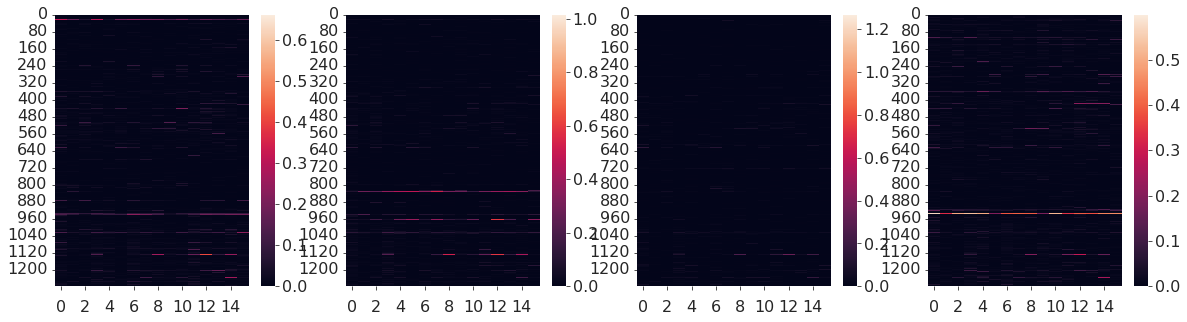

In [68]:
fig, axes = plt.subplots(1,4,figsize=(20,5))    
for ii, iID in enumerate(mainseq_ids):
    PSTH = np.stack(PSTH_list[ii],axis=1)

    divisor = np.max(PSTH,axis=1).reshape(-1,1) - np.min(PSTH,axis=1).reshape(-1,1)
    PSTH_norm = 2*np.divide(PSTH - np.min(PSTH,axis=1).reshape(-1,1),divisor,out=np.zeros(PSTH.shape,dtype=np.float32),where = divisor!=0) - 1
    ax = axes[ii]
    sns.heatmap(PSTH,ax=ax)#,vmin=-1,vmax=1,cbar=True,cmap='RdBu_r')
#     ax.plot(np.mean(PSTH_norm,axis=0))

In [72]:
8000*0.25/60

33.333333333333336

In [35]:
[p.shape for p in PSTH_list[ii]]

[(1278,), (1278,), (1278,)]

In [ ]:
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
fig, axes = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.25,'wspace':0.25},sharex=True,sharey=True)
method='kfold' 
classifier = 'SVM'
block_str = 'oddball'

cm_list = []; cmz_list = []
for ii, area in enumerate(areanames):
    
    #Loop over depth as well
    for jj, depthstr in enumerate(['superficial','deep']):

        locstr = '{}_{}'.format(area,depthstr)
        fpath = os.path.join(SaveDir,'DecodeTimePseudoPop_usingMSimgs_3epochs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        ax=axes[jj,ii]

        cm_list.append(np.mean(confusion_mat,axis=0))
        cmz_list.append(np.mean(confusion_z,axis=0))
        dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=ax,class_labels=['Early','Middle','Late'],title=f'{locstr}',annot=False,clims=[0,1])
        if jj == 1:
            axes[jj,ii].set_xlabel('Decoded Epoch',fontsize=18)
        else:
            axes[jj,ii].set_xlabel('')
            
        if ii == 0:
            axes[jj,ii].set_ylabel('Actual Epoch',fontsize=18)
        else:
            axes[jj,ii].set_ylabel('')
plt.suptitle('Quantifying representational drift within sequence context',fontsize=22)
plt.savefig(os.path.join('./plots/paper','oddball-block_time_decoding_{}_{}.pdf'.format(method,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
cm_list.append(np.mean(confusion_mat,axis=0))
cmz_list.append(np.mean(confusion_z,axis=0))

cm = np.mean(cm_list,axis=0); cmz = np.mean(cmz_list,axis=0)

fig, ax = plt.subplots(figsize=(4,4))
dc.plot_decoding_accuracy(cm,cmz,ax=ax,class_labels=['Early','Middle','Late'],annot=True,clims=[0,1])
ax.set_xlabel('Predicted Epoch',fontsize=18)

ax.set_ylabel('Actual Epoch',fontsize=18)

# plt.suptitle('Quantifying representational drift within sequence context',fontsize=22)
plt.savefig(os.path.join('./plots/paper','oddball-block_time_decoding_3epochs_{}_{}.pdf'.format(method,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

In [33]:
areanames = ['VISp', 'VISpm','RSP']

## Cross-Sequence Generalization Performance

In [ ]:
method='kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')
    
method='kfold' 
classifier = 'SVM'

nEpochs = 3
block_str = 'oddball'
for area in areanames:
    cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,4,figsize=(20,5))
        
        X_list = []; Y_list = []; Y_sort_list = []
        
        #Get trials where MS images are presented in the randomized control pre context
        X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
        Y_sort = [f'{int(y)}_0' for y in Y]; Y_sort_list.append(Y_sort)
        X_list.append(X); Y_list.append(Y)
        
        #Get trials where MS images are presented in the sequence context
        for i in range(nEpochs):
#             slindy = slice(i*1000,i*1000+120)
            slindy = slice(i*3000+120,i*3000+240)
            X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
            Y_sort = [f'{int(y)}_{i+1}' for y in Y]; Y_sort_list.append(Y_sort)
            X_list.append(X); Y_list.append(Y)
            
        #Get trials where MS images are presented in the transition control context
        X, Y, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
        Y_sort = [f'{int(y)}_5' for y in Y]; Y_sort_list.append(Y_sort)
        X_list.append(X); Y_list.append(Y)
        
        #Get trials where MS images are presented in the randomized control post context
        X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_post'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
        Y_sort = [f'{int(y)}_6' for y in Y]; Y_sort_list.append(Y_sort)
        X_list.append(X); Y_list.append(Y)
        
        X = np.concatenate(X_list); Y = np.concatenate(Y_list); Y_sort = np.concatenate(Y_sort_list)
        
        nClasses = len(X_list)
        confusion_mat = np.zeros((len(mainseq_ids), nClasses, nClasses))
        confusion_shf = np.zeros((len(mainseq_ids), nClasses, nClasses))
        confusion_z = np.zeros((len(mainseq_ids), nClasses, nClasses))
        for ii, iID in enumerate(mainseq_ids):
            indy = np.where(Y == iID)
            X_sub = X[indy]; Y_sort_sub = [Y_sort[ii] for ii in indy]
            Y_sub = np.array(Y_sort_sub).reshape(-1,)
#             pdb.set_trace()

            confusion_mat[ii], confusion_shf[ii], confusion_z[ii] = dc.cross_validate(X_sub,Y_sub,clabels=np.unique(Y_sort_sub),classifier=classifier,method=method,parallel=True,nProcesses=75)

#             fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
#             with h5py.File(fpath,'w') as h5file:
#                 h5file.create_dataset('confusion_mat',data=confusion_mat)
#                 h5file.create_dataset('confusion_shf',data=confusion_shf)
#                 h5file.create_dataset('confusion_z',data=confusion_z)
#                 h5file.create_dataset('area',data=area)
#                 h5file.create_dataset('classifier',data=classifier)
#                 h5file.create_dataset('method',data=method)


            dc.plot_decoding_accuracy(confusion_mat[ii],confusion_z[ii],ax=axes[ii],class_labels=np.arange(nClasses),title=mainseq_labels[ii],annot=False,clims=[0,1])
            axes[ii].set_xlabel('Test Epoch')
            axes[ii].set_ylabel('Training Epoch')

        plt.suptitle('Cross-Condition Generalization Performance using main-seq; {}, {} classifier'.format(locstr,classifier))
#         plt.savefig(os.path.join('./plots/paper','time_decoding_CCGP_{}_{}_{}.png'.format(locstr,method,classifier)))
        
#         plt.show()
#         pdb.set_trace()

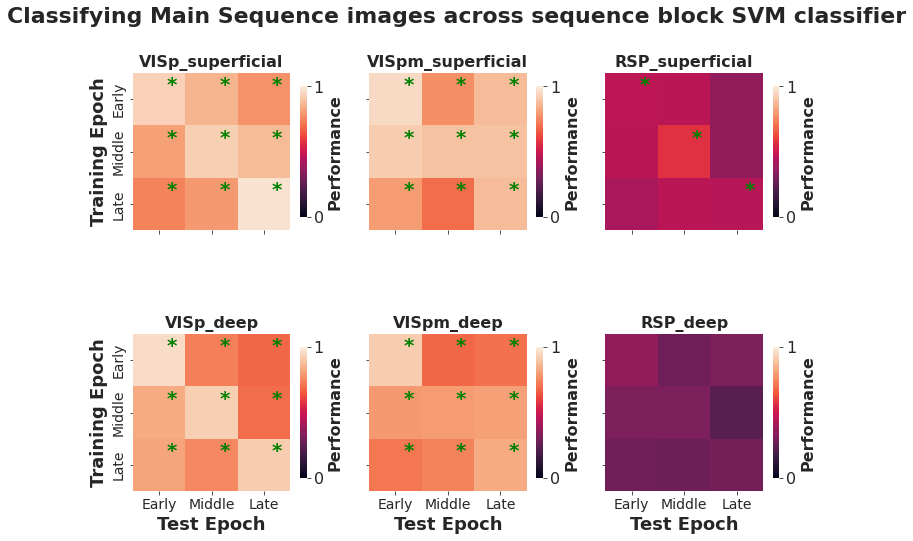

In [124]:
method='kfold'
reduce_dim=False
parallel = True; import multiprocessing as mp
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')
    
method='kfold' 
classifier = 'SVM'

slice_list = [slice(0,240),slice(3080,3320),slice(6160,6400)]
slice_str = ['first240','middle240','last240']

# slice_list = [slice(0,120),slice(3080,3200),slice(6280,6400)]
# slice_str = ['first120','middle120','last120']
fig, axes = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.5},sharex=True,sharey=True)
nEpochs = 3
block_str = 'oddball'
for ii, area in enumerate(areanames):
    cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        
        
#         #Get trials where MS images
        X_list = []; Y_list = []; Y_sort_list = []
        for i in range(nEpochs):
            slindy = slice(i*3000+120,i*3000+240)
            X, Y, _ = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
            Y_sort = [f'{int(y)}_{i}' for y in Y]; Y_sort_list.append(Y_sort)
            X_list.append(X); Y_list.append(Y)

#         #Get trials where MS images are presented in the randomized control pre context
#         X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
#         Y_sort = [f'{int(y)}_0' for y in Y]; Y_sort_list.append(Y_sort)
#         X_list.append(X); Y_list.append(Y)
        
#         #Get trials where MS images are presented in the sequence context
#         for i in range(nEpochs):
# #             slindy = slice(i*1000,i*1000+120)
#             slindy = slice(i*3000+120,i*3000+240)
#             X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
#             Y_sort = [f'{int(y)}_{i+1}' for y in Y]; Y_sort_list.append(Y_sort)
#             X_list.append(X); Y_list.append(Y)
            
#         #Get trials where MS images are presented in the transition control context
#         X, Y, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
#         Y_sort = [f'{int(y)}_5' for y in Y]; Y_sort_list.append(Y_sort)
#         X_list.append(X); Y_list.append(Y)
        
#         #Get trials where MS images are presented in the randomized control post context
#         X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_post'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
#         Y_sort = [f'{int(y)}_6' for y in Y]; Y_sort_list.append(Y_sort)
#         X_list.append(X); Y_list.append(Y)
        
        if parallel:
            pool = mp.Pool(processes=40)
            processes = []
        results = []
    
        for iTrain, (X_train,Y_train) in enumerate(zip(X_list,Y_list)):
            for iTest, (X_test,Y_test) in enumerate(zip(X_list,Y_list)):
                if iTrain == iTest:
                    continue
                    
                if parallel:
                    processes.append(pool.apply_async(dc.decode_labels,args=(X_train,Y_train,None,None,classifier,mainseq_ids,X_test,Y_test)))
            
        #Extract results from parallel kfold processing
        if parallel:
            results = [p.get() for p in processes]
            pool.close()
        
        nClasses = nEpochs
        drift_confusion_mat = np.zeros((nClasses,nClasses))
        drift_confusion_z = np.zeros((nClasses,nClasses))
        drift_confusion_shf = np.zeros((nClasses,nClasses))
        pool = mp.Pool(processes=40); processes = []
        for iEpoch, (X,Y) in enumerate(zip(X_list,Y_list)):
            processes.append(pool.apply_async(dc.cross_validate,args=(X,Y,), kwds={'classifier':classifier,'clabels':mainseq_ids,'method':'L1O'}))
#             confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,clabels=mainseq_ids,classifier=classifier,method='L1O')

        for iEpoch,p in enumerate(processes):
            confusion_mat = p.get()[0]
            confusion_shf = p.get()[1]
            confusion_z = p.get()[2]
            drift_confusion_z[iEpoch,iEpoch] = np.mean(np.diag(confusion_z))
            drift_confusion_mat[iEpoch,iEpoch] = np.mean(np.diag(confusion_mat))
            drift_confusion_shf[iEpoch,iEpoch] = np.mean(np.diag(confusion_z))
        pool.close()
        

        counter = 0
        for iTrain, (X_train,Y_train) in enumerate(zip(X_list,Y_list)):
            for iTest, (X_test,Y_test) in enumerate(zip(X_list,Y_list)):
                if iTrain == iTest:
                    continue
                kfold_hits, kfold_shf = results[counter]

                confusion_mat = kfold_hits/np.sum(kfold_hits,axis=1).reshape(-1,1)
                confusion_shf = np.zeros(kfold_shf.shape)
                for i in range(kfold_shf.shape[0]):
                    confusion_shf[i] = kfold_shf[i]/np.sum(kfold_shf[i],axis=1).reshape(-1,1)
                m_shf, s_shf = np.mean(confusion_shf,axis=0), np.std(confusion_shf,axis=0)
                confusion_z = (confusion_mat - m_shf)/s_shf

                drift_confusion_z[iTrain,iTest] = np.mean(np.diag(confusion_z))
                drift_confusion_mat[iTrain,iTest] = np.mean(np.diag(confusion_mat))
                drift_confusion_shf[iTrain,iTest] = np.mean(np.diag(m_shf))
                counter+=1
        

        fpath = os.path.join(SaveDir,'decoding-drift_oddball-block_{}_{}.mat'.format(locstr,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('drift_confusion_z',data=drift_confusion_z)
            h5file.create_dataset('drift_confusion_mat',data=drift_confusion_mat)
            h5file.create_dataset('drift_confusion_shf',data=drift_confusion_shf)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)

        dc.plot_decoding_accuracy(drift_confusion_mat,drift_confusion_z,ax=axes[jj,ii],class_labels=['Early','Middle','Late'],title=f'{locstr}',annot=False,clims=[0,1])
        if jj == 1:
            axes[jj,ii].set_xlabel('Test Epoch',fontsize=18)
        else:
            axes[jj,ii].set_xlabel('')
            
        if ii == 0:
            axes[jj,ii].set_ylabel('Training Epoch',fontsize=18)
        else:
            axes[jj,ii].set_ylabel('')
plt.suptitle('Classifying Main Sequence images across sequence block {} classifier'.format(classifier),fontsize=22)
plt.savefig(os.path.join('./plots/paper','sequence-block_MS-drift_CCGP_{}_{}.pdf'.format(method,classifier)))

In [ ]:
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
fig, axes = plt.subplots(2,1,figsize=(8,4),gridspec_kw={'hspace':0.25,'wspace':0.25},sharex=True,sharey=True)
area_labels = ['V1','RSP']
block_str = 'oddball'
for ii, area in enumerate(['VISp','RSP']):
    
    #Loop over depth as well
    for jj, depthstr in enumerate(['superficial','deep']):
        depthstr = 'superficial'
        locstr = '{}_{}'.format(area,depthstr)
        fpath = os.path.join(SaveDir,'decoding-drift_oddball-block_{}_{}.mat'.format(locstr,classifier))
        with h5py.File(fpath,'r') as h5file:
            drift_confusion_z = np.array(h5file['drift_confusion_z'])
            drift_confusion_mat = np.array(h5file['drift_confusion_mat'])
            drift_confusion_shf = np.array(h5file['drift_confusion_shf'])

        dc.plot_decoding_accuracy(drift_confusion_mat,drift_confusion_z,ax=axes[jj,ii],class_labels=['Early','Middle','Late'],title=f'{depthstr.capitalize()} {area_labels[ii]}',annot=False,clims=[0,1])
        if jj == 1:
            axes[jj,ii].set_xlabel('Test Epoch',fontsize=18)
        else:
            axes[jj,ii].set_xlabel('')
            
        if ii == 0:
            axes[jj,ii].set_ylabel('Training Epoch',fontsize=18)
        else:
            axes[jj,ii].set_ylabel('')
# plt.suptitle('Within context generalization performance',fontsize=22)
plt.savefig(os.path.join('./plots/paper','oddball-block_MS-drift_CCGP_{}_{}.pdf'.format(method,classifier)))

In [128]:
axes


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [ ]:
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
fig, axes = plt.subplots(2,1,figsize=(4,8),gridspec_kw={'hspace':0.05},sharex=True,sharey=True)
area_labels = ['RSP','V1']
block_str = 'oddball'
for ii, area in enumerate(['RSP','VISp']):
    
    #Loop over depth as well
#     for jj, depthstr in enumerate(['superficial','deep']):
    
    if area == 'RSP':
        depthstr = 'deep'
        
        locstr = '{}_{}'.format(area,depthstr)
        fpath = os.path.join(SaveDir,'decoding-drift_oddball-block_{}_{}.mat'.format(locstr,classifier))
        with h5py.File(fpath,'r') as h5file:
            drift_confusion_z2 = np.array(h5file['drift_confusion_z'])
            drift_confusion_mat2 = np.array(h5file['drift_confusion_mat'])
      
    depthstr = 'superficial'
    locstr = '{}_{}'.format(area,depthstr)
    fpath = os.path.join(SaveDir,'decoding-drift_oddball-block_{}_{}.mat'.format(locstr,classifier))
    with h5py.File(fpath,'r') as h5file:
        drift_confusion_z = np.array(h5file['drift_confusion_z'])
        drift_confusion_mat = np.array(h5file['drift_confusion_mat'])
        drift_confusion_shf = np.array(h5file['drift_confusion_shf'])

    if area == 'RSP':
        drift_confusion_z2[np.diag_indices(3)] = np.diag(drift_confusion_z)
        drift_confusion_mat2[np.diag_indices(3)] = np.diag(drift_confusion_mat)
        drift_confusion_mat = drift_confusion_mat2
        drift_confusion_z = drift_confusion_z2
   
    dc.plot_decoding_accuracy(drift_confusion_mat,drift_confusion_z,ax=axes[ii],class_labels=['Early','Middle','Late'],title=f'{depthstr.capitalize()} {area_labels[ii]}',annot=True,clims=[0,1])

    if ii == 1:
        axes[ii].set_xlabel('Test Epoch',fontsize=18)



    axes[ii].set_ylabel('Training Epoch',fontsize=18)

# plt.suptitle('Within context generalization performance',fontsize=22)
plt.savefig(os.path.join('./plots/paper','oddball-block_MS-drift_CCGP_3epochs_{}_{}.pdf'.format(method,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
import matplotlib as mpl
mpl.rcParams.update({'font.size':         12,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':   "DejaVu Sans",
                     'font.family':       "sans-serif",
                     'pdf.fonttype':      42,
                     'xtick.labelsize': 10,
                     'ytick.labelsize': 10,
                    })

In [268]:
slindy = slice(iEpoch*1000+120,iEpoch*1000+240)
X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(3000,3120))


In [272]:
pca = PCA(n_components=3)
X_transform = pca.fit_transform(X)

In [287]:
import matplotlib as mpl
mpl.rcParams.update({'font.size':         16,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':   "DejaVu Sans",
                     'font.family':       "sans-serif",
                     'pdf.fonttype':      42,
                     'xtick.labelsize': 10,
                     'ytick.labelsize': 10,
                    })

## PCA of main-sequence PSTHs

In [113]:
PSTH_dict = {}

for area in tqdm(areanames):
    cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        PSTH_list = []
        
        #Get trials where MS images are presented in the randomized control pre context
        X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
        for iSeq, iID in enumerate(mainseq_ids):
            indy = np.where(Y == iID)[0]
            PSTH_list.append(np.mean(X[indy],axis=0))
        
        X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(5000,5240))
        #Calculate PSTHs for each image within these "epochs"
        for iSeq, iID in enumerate(mainseq_ids):
            indy = np.where(Y == iID)[0]
            PSTH_list.append(np.mean(X[indy],axis=0))
                
        #Get trials where MS images are presented in the transition control context
        X, Y, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
        for iSeq, iID in enumerate(mainseq_ids):
            indy = np.where(Y == iID)[0]
            PSTH_list.append(np.mean(X[indy],axis=0))
            
        #Get trials where MS images are presented in the randomized control post context
        X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_post'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
        for iSeq, iID in enumerate(mainseq_ids):
            indy = np.where(Y == iID)[0]
            PSTH_list.append(np.mean(X[indy],axis=0))
        
        PSTH_dict[locstr] = np.stack(PSTH_list)
                
        

100%|██████████| 3/3 [00:27<00:00,  9.08s/it]


In [114]:
def dim_reduction_plot(X, method='pca',nLatents=2,pdfdoc=None):
    if method == 'pca':
        pca = PCA(n_components=nLatents)
        X_transform = pca.fit_transform(X)
#         print('Variance explained with {}, {} components: {:.2f}'.format(method,nLatents,np.sum(pca.explained_variance_ratio_)))
    elif method == 'mds':
        mds = MDS(n_components=nLatents)
        X_transform = mds.fit_transform(X)
    else:
        print(f'Method {method} not implemented')
        return 0

    overall_index = 0
    seq_index = 0
    marker_list = ['$A$','$B$','$C$','$D$']
    cm = plt.get_cmap('Reds')
    ##plot 2D
    if nLatents == 2:
        fig, ax = plt.subplots(figsize=(3,3))
        ax.set_title(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        
        for ii, context in enumerate(blocknames):
            plot_indices = overall_index + np.arange(0,4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35,lw=3)

            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[ii],marker=marker_list[jj],s=150,zorder=3)
                overall_index += 1
       
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
                
    elif nLatents == 3:
        
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection='3d')
        ax.set_title(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        ms=150
        
        for ii, context in enumerate(blocknames):
            plot_indices = overall_index + np.arange(0,4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.35,lw=3)

            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[ii],marker=marker_list[jj],s=ms,zorder=3)
                seq_index += 1; overall_index += 1
                
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
    if pdfdoc is not None:
        pdfdoc.savefig(fig)
        plt.close(fig)
    else:
        return fig

In [ ]:
# pdfdoc = PdfPages('./plots/paper/pca_PSTH_pseudopopulation.pdf')
from sklearn.manifold import MDS
for area in areanames:
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        
        X = PSTH_dict[locstr]

        X_standardized = st.zscore(X,axis=1)
#         fpath = './plots/paper/pca3D_PSTH_pseudopop_{}.pdf'.format(locstr)
        fig = dim_reduction_plot(X_standardized, method='mds',nLatents=3,pdfdoc=None)
#         plt.savefig(fpath, facecolor='white', transparent=True, bbox_inches='tight')
        

In [51]:
PSTH_mainseq_dict = {}

for area in tqdm(areanames):
    cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        PSTH_list = []
        
        #Get trials where MS images are presented in the randomized control pre context
        X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
        for iSeq, iID in enumerate(mainseq_ids):
            indy = np.where(Y == iID)[0]
            PSTH_list.append(np.mean(X[indy],axis=0))
        
        nEpochs = 7; nNeurons = len(cell_ids_perdepth)
        for iEpoch in range(nEpochs):
#             slindy = slice(iEpoch*2000+120,iEpoch*2000+240)
#             slindy = slice(iEpoch*3000+120,iEpoch*3000+240)
            slindy = slice(iEpoch*1000+120,iEpoch*1000+240)
            X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
            #Calculate PSTHs for each image within these "epochs"
            for iSeq, iID in enumerate(mainseq_ids):
                indy = np.where(Y == iID)[0]
                PSTH_list.append(np.mean(X[indy],axis=0))
                
        #Get trials where MS images are presented in the transition control context
        X, Y, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
        for iSeq, iID in enumerate(mainseq_ids):
            indy = np.where(Y == iID)[0]
            PSTH_list.append(np.mean(X[indy],axis=0))
            
        #Get trials where MS images are presented in the randomized control post context
        X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_post'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
        for iSeq, iID in enumerate(mainseq_ids):
            indy = np.where(Y == iID)[0]
            PSTH_list.append(np.mean(X[indy],axis=0))
        
        PSTH_mainseq_dict[locstr] = np.stack(PSTH_list)
                
        

100%|██████████| 3/3 [02:59<00:00, 59.94s/it]


In [146]:
def dim_reduction_plot_mainseq(X, method='pca',nLatents=2,pdfdoc=None,nEpochs=7):
    if method == 'pca':
        pca = PCA(n_components=nLatents)
        X_transform = pca.fit_transform(X)
#         print('Variance explained with {}, {} components: {:.2f}'.format(method,nLatents,np.sum(pca.explained_variance_ratio_)))
    elif method == 'mds':
        mds = MDS(n_components=nLatents)
        X_transform = mds.fit_transform(X)
    else:
        print(f'Method {method} not implemented')
        return 0

    overall_index = 0
    seq_index = 0
    marker_list = ['$A$','$B$','$C$','$D$']
    cm = plt.get_cmap('Reds')
    ms = 150
    ##plot 2D
    if nLatents == 2:
        fig, ax = plt.subplots(figsize=(4,4))
        ax.set_title(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        
        ##===== Rand-Ctrl Pre Context =====##
        #Get trials where MS images are presented in the randomized control pre context
        plot_indices = np.arange(0,4)
        ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35,lw=3)
            
        for jj, iID in enumerate(mainseq_ids):
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[0],marker=marker_list[jj],s=ms,zorder=3)
            overall_index += 1
        
        ##===== Sequence Context =====##
        #4 epochs of ABCD in sequence context
        for ii in range(nEpochs-1):
            plot_indices = overall_index + np.arange(0,4)
#             ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35)

            for jj, iID in enumerate(mainseq_ids):
#                 ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cm((seq_index+2)/(14)),marker=marker_list[jj],s=75,zorder=3)
                seq_index += 1; overall_index += 1
                
                
        plot_indices = overall_index + np.arange(0,4)
        ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35,lw=3)

        for jj, iID in enumerate(mainseq_ids):
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[1],marker=marker_list[jj],s=ms,zorder=3)
            overall_index += 1
                
        ##===== Trans-Ctrl Context =====##
        #Get trials where MS images are presented in the transition control context
        plot_indices = overall_index + np.arange(0,4)
        ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35,lw=3)
            
        for jj, iID in enumerate(mainseq_ids):
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker=marker_list[jj],s=ms,zorder=3)
            overall_index += 1
            
        ##===== Rand-Ctrl Post Context =====##
        #Get trials where MS images are presented in the randomized control post context
        plot_indices = overall_index + np.arange(0,4)
        ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35,lw=3)
            
        for jj, iID in enumerate(mainseq_ids):
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[3],marker=marker_list[jj],s=ms,zorder=3)
            overall_index += 1
            
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
                
    elif nLatents == 3:
        
        fig = plt.figure(figsize=(4,4))
        ax = plt.axes(projection='3d')
        ax.set_title(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        ms=150
        ##===== Rand-Ctrl Pre Context =====##
        #Get trials where MS images are presented in the randomized control pre context
        plot_indices = np.arange(0,4)
        ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.5,lw=3)
            
        for jj, iID in enumerate(mainseq_ids):
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[0],marker=marker_list[jj],s=ms,zorder=3)
            overall_index += 1
        
        ##===== Sequence Context =====##
        #4 epochs of ABCD in sequence context
        for ii in range(nEpochs-1):
            plot_indices = overall_index + np.arange(0,4)
#             ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.35)

            for jj, iID in enumerate(mainseq_ids):
#                 ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cm((seq_index+2)/(14)),marker=marker_list[jj],s=ms,zorder=3)
                seq_index += 1; overall_index += 1
                
            
        plot_indices = overall_index + np.arange(0,4)
        ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.5,lw=3)

        for jj, iID in enumerate(mainseq_ids):
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[1],marker=marker_list[jj],s=ms,zorder=3)
            seq_index += 1; overall_index += 1
                
                
        ##===== Trans-Ctrl Context =====##
        #Get trials where MS images are presented in the transition control context
        plot_indices = overall_index + np.arange(0,4)
        ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.5,lw=3)
            
        for jj, iID in enumerate(mainseq_ids):
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[2],marker=marker_list[jj],s=ms,zorder=3)
            overall_index += 1
            
        ##===== Rand-Ctrl Post Context =====##
        #Get trials where MS images are presented in the randomized control post context
        plot_indices = overall_index + np.arange(0,4)
        ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.5,lw=3)
            
        for jj, iID in enumerate(mainseq_ids):
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[3],marker=marker_list[jj],s=ms,zorder=3)
            overall_index += 1
            
        ax.set_xlabel('PC1',fontsize=18); ax.set_ylabel('PC2',fontsize=18); ax.set_zlabel('PC3',fontsize=18)
#         ax.set_xlim([-20,20]);ax.set_ylim([-20,20]);ax.set_zlim([-20,20])
#         ax.set_xticks([-20,-10,0,10,20]);ax.set_yticks([-20,-10,0,10,20]);ax.set_zticks([-20,-10,0,10,20])
#         ax.set_xticklabels([-20,'','','',20],fontsize=16);ax.set_yticklabels([-20,'','','',20],fontsize=16);ax.set_zticklabels([-20,'','','',20],fontsize=16)
    if pdfdoc is not None:
        pdfdoc.savefig(fig)
        plt.close(fig)
    else:
        return fig

In [ ]:
# pdfdoc = PdfPages('./plots/paper/pca_PSTH_pseudopopulation.pdf')
from sklearn.manifold import MDS
for area in areanames:
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        
        X = PSTH_mainseq_dict[locstr]

        X_standardized = st.zscore(X,axis=1)
        fpath = './plots/paper/pca2d_PSTH_pseudopop_{}.pdf'.format(locstr)
        fig = dim_reduction_plot_mainseq(X_standardized, method='pca',nLatents=2,pdfdoc=None)
        plt.savefig(fpath, facecolor='white', transparent=True, bbox_inches='tight')
        

In [262]:
mainseq_labels

['A', 'B', 'C', 'D']

In [ ]:
area = 'RSP'; depthstr = 'superficial'  
locstr = '{}_{}'.format(area,depthstr)
X = PSTH_mainseq_dict[locstr]

X_standardized = st.zscore(X,axis=1)
fpath = './plots/paper/pca3D_PSTH_pseudopop_{}_mini.pdf'.format(locstr)
fig = dim_reduction_plot_mainseq(X_standardized, method='pca',nLatents=3,pdfdoc=None)
plt.savefig(fpath, facecolor='white', transparent=True, bbox_inches='tight')

## PCA of ABCXABCD PSTHs

In [ ]:
PSTH_ABCX_dict = {}

block_str = 'oddball'
for area in tqdm(areanames):
    cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        PSTH_list = []; imgID_list = []
        
        nEpochs = 3; 
        for iEpoch in range(nEpochs):
            slindy = slice(iEpoch*3000+120,iEpoch*3000+240)
            X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
            #Calculate PSTHs for each image within these "epochs"
            for iSeq, iID in enumerate(mainseq_ids):
                indy = np.where(Y == iID)[0]
                PSTH_list.append(np.mean(X[indy],axis=0)); imgID_list.append(iID)
                
        
        #Get trials where MS images are presented in the sequence context relative to the oddball
        X1, Y1, Y_sort1 = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCX')
        X2, Y2, Y_sort2 = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X-ABCD')
        
        for iSeq, iID in enumerate(oddball_ids):
            indy = np.where(Y1 == iID)[0]
            #Calculate PSTH for ABC before this X presentation
            for i in range(1,4):
                indy2 = indy - i
                PSTH_list.append(np.mean(X1[indy2],axis=0)); imgID_list.append(mainseq_ids[i-1])

            #Append PSTH of this oddball
            PSTH_list.append(np.mean(X1[indy],axis=0)); imgID_list.append(iID)

            indy = np.where(Y2 == iID)[0]
            #Calculate PSTH for ABCD after this X presentation
            for i in range(1,5):
                indy2 = indy + i
                PSTH_list.append(np.mean(X2[indy2],axis=0));imgID_list.append(mainseq_ids[i-1])
        
        
        #Get trials where MS images are presented in the transition control context
        X, Y, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
        for iSeq, iID in enumerate(mainseq_ids):
            indy = np.where(Y == iID)[0]
            PSTH_list.append(np.mean(X[indy],axis=0)); imgID_list.append(iID)
            
        #Get trials where MS images are presented in the transition_control context relative to the oddball
        X1, Y1, Y_sort1 = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='CX')
        X2, Y2, Y_sort2 = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='XA')

        for iSeq, iID in enumerate(oddball_ids):
            ##===== CX =====##
            indy = np.where(Y1 == iID)[0]

            #Calculate PSTH for C before this X presentation
            PSTH_list.append(np.mean(X1[indy-1],axis=0)); imgID_list.append(mainseq_ids[-2])

            #Append PSTH of this oddball
            PSTH_list.append(np.mean(X1[indy],axis=0)); imgID_list.append(iID)

            ##===== XA =====##
            indy = np.where(Y2 == iID)[0]

            #Calculate PSTH of this oddball
            PSTH_list.append(np.mean(X2[indy],axis=0)); imgID_list.append(iID)

            #Calculate PSTH for the A after this X presentation
            PSTH_list.append(np.mean(X2[indy+1],axis=0)); imgID_list.append(mainseq_ids[0])
            
        
        PSTH_ABCX_dict[locstr] = np.stack(PSTH_list)
                
        

In [ ]:
def dim_reduction_plot_ABCX(X, method='pca',nLatents=2,pdfdoc=None,nEpochs=3):
    if method == 'pca':
        pca = PCA(n_components=nLatents)
        X_transform = pca.fit_transform(X)
        print('Variance explained with {}, {} components: {:.2f}'.format(method,nLatents,np.sum(pca.explained_variance_ratio_)))
    elif method == 'mds':
        mds = MDS(n_components=nLatents)
        X_transform = mds.fit_transform(X)
    else:
        print(f'Method {method} not implemented')
        return 0

    overall_index = 0
    seq_index = 0
    marker_list = ['$A$','$B$','$C$','$D$']
    cm = plt.get_cmap('Greys')
    ##plot 2D
    if nLatents == 2:
        fig, axes = plt.subplots(1,4,figsize=(24,6))#,sharex=True,sharey=True)
        plt.suptitle(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
#         ax = axes[1]
# #         3 epochs of ABCD in sequence context
#         for ii in range(nEpochs):
#             plot_indices = np.arange(ii*4,(ii+1)*4)
#             ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35)

#             for jj, iID in enumerate(mainseq_ids):
#                 ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cm((seq_index+2)/(14)),marker=marker_list[jj],s=75,zorder=3)
#                 seq_index += 1; overall_index += 1

        #ABCXABCD in sequence context
        for ii, iID in enumerate(oddball_ids):
            
            ax = axes[0]; ax.set_title('ABCX')
            plot_indices = overall_index + np.arange(0,4)
            #Plot lines for ABCX
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=0,alpha=0.35,ls='--')

            #Plot ABC of ABCX sequence
            for jj, iID in enumerate(mainseq_ids[:-1]):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[1],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1

            #Plot X of ABCX sequence
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[1],marker='$X$',s=75,zorder=2)
            overall_index += 1

            ax = axes[1]; ax.set_title('XABCD')
            #Plot lines for ABCD
            plot_indices = overall_index +  np.arange(0,4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=0,alpha=0.35,ls='-')

            #Plot ABCD of ABCD sequence
            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[1],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1

        ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
        
#         ax = axes[2]
#         #ABCD in transition-control context
#         #Plot lines for ABCD
#         plot_indices = overall_index + np.arange(0,4)
#         ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color='k',zorder=0,alpha=0.5,ls='-')

#         #Plot ABCD of ABCD sequence
#         for jj, iID in enumerate(mainseq_ids):
#             ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color='k',marker=marker_list[jj],s=75,zorder=2)
#             overall_index += 1

        #CX and XA transitions
        for ii, iID in enumerate(oddball_ids):
            
            ax = axes[2];ax.set_title('CX')
            ##===== CX =====##
            plot_indices = overall_index + np.arange(0,2)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[2],zorder=0,alpha=0.35,ls='--')


            #plot PSTH for C before this X presentation
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$C$',s=75,zorder=2)
            overall_index += 1

            #plot PSTH for this oddball
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$X$',s=75,zorder=2)
            overall_index += 1

            ax = axes[3];ax.set_title('XA')
            ##===== XA =====##
            plot_indices = overall_index + np.arange(0,2)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[2],zorder=0,alpha=0.35,ls='-')

            #plot PSTH for this oddball
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$X$',s=75,zorder=2)
            overall_index += 1

            #plot PSTH for C before this X presentation
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$A$',s=75,zorder=2)
            overall_index += 1
    
                
    elif nLatents == 3:
        
        fig = plt.figure(figsize=(24,6))
#         ax = plt.axes(projection='3d')
        ax0 = fig.add_subplot(1, 4, 1, projection='3d'); ax1 = fig.add_subplot(1, 4, 2, projection='3d')
        ax2 = fig.add_subplot(1, 4, 3, projection='3d'); ax3 = fig.add_subplot(1, 4, 4, projection='3d')
        plt.suptitle(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        
#         #3 epochs of ABCD in sequence context
#         for ii in range(nEpochs):
#             plot_indices = np.arange(ii*4,(ii+1)*4)
#             ax1.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.35)

#             for jj, iID in enumerate(mainseq_ids):
#                 ax1.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cm((seq_index+2)/(14)),marker=marker_list[jj],s=75,zorder=3)
#                 seq_index += 1; overall_index += 1

        ax0.set_title('ABCX');
        ax1.set_title('XABCD')
        #ABCXABCD in sequence context
        for ii, iID in enumerate(oddball_ids):
            plot_indices = overall_index + np.arange(0,4)
            #Plot lines for ABCX
            ax0.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[1],zorder=0,alpha=0.35,ls='--')

            #Plot ABC of ABCX sequence
            for jj, iID in enumerate(mainseq_ids[:-1]):
                ax0.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[1],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1

            #Plot X of ABCX sequence
            ax0.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[1],marker='$X$',s=75,zorder=2)
            overall_index += 1

            #Plot lines for ABCD
            plot_indices = overall_index +  np.arange(0,4)
            ax1.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[1],zorder=0,alpha=0.35,ls='-')

            #Plot ABCD of ABCD sequence
            for jj, iID in enumerate(mainseq_ids):
                ax1.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[1],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1

#         #ABCD in transition-control context
#         #Plot lines for ABCD
#         plot_indices = overall_index + np.arange(0,4)
#         ax2.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color='k',zorder=0,alpha=0.5,ls='-')

#         #Plot ABCD of ABCD sequence
#         for jj, iID in enumerate(mainseq_ids):
#             ax2.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color='k',marker=marker_list[jj],s=75,zorder=2)
#             overall_index += 1

        ax2.set_title('CX')
        #CX and XA transitions
        for ii, iID in enumerate(oddball_ids):
            
            ##===== CX =====##
            plot_indices = overall_index + np.arange(0,2)
            ax2.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[2],zorder=0,alpha=0.35,ls='--')


            #plot PSTH for C before this X presentation
            ax2.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$C$',s=75,zorder=2)
            overall_index += 1

            #plot PSTH for this oddball
            ax2.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$X$',s=75,zorder=2)
            overall_index += 1

            ax3.set_title('XA')
            ##===== XA =====##
            plot_indices = overall_index + np.arange(0,2)
            ax3.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[2],zorder=0,alpha=0.35,ls='-')

            #plot PSTH for this oddball
            ax3.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$X$',s=75,zorder=2)
            overall_index += 1

            #plot PSTH for C before this X presentation
            ax3.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$A$',s=75,zorder=2)
            overall_index += 1
            
        for ax in [ax0,ax1,ax2,ax3]:
            ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
    if pdfdoc is not None:
        pdfdoc.savefig(fig)
    else:
        return fig

In [ ]:


# area = 'VISp'; depthstr = 'superficial'
# locstr = '{}_{}'.format(area,depthstr)
# X = PSTH_ABCX_dict[locstr]
# X = st.zscore(X,axis=0)
# X = X[12:]
# # print(X.shape)
# X = np.concatenate((X[:80,:],X[84:,:]))
# # pdb.set_trace()
# fig = dim_reduction_plot_ABCX(X, method='pca',nLatents=2,pdfdoc=None)



for area in areanames:
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        
        X = PSTH_ABCX_dict[locstr]
        
        X = X[12:]
        # print(X.shape)
        X = np.concatenate((X[:80,:],X[84:,:]))
        X = st.zscore(X,axis=0)
        fpath = './plots/paper/pca2D_ABCX_PSTH_pseudopop_{}.pdf'.format(locstr)
        fig = dim_reduction_plot_ABCX(X, method='pca',nLatents=2,pdfdoc=None)
        plt.savefig(fpath)


In [ ]:
def dim_reduction_plot_transctrl(X, method='pca',nLatents=2,pdfdoc=None):
    if method == 'pca':
        pca = PCA(n_components=nLatents)
        X_transform = pca.fit_transform(X)
        print('Variance explained with {}, {} components: {:.2f}'.format(method,nLatents,np.sum(pca.explained_variance_ratio_)))
    elif method == 'mds':
        mds = MDS(n_components=nLatents)
        X_transform = mds.fit_transform(X)
    else:
        print(f'Method {method} not implemented')
        return 0

    overall_index = 0
    marker_list = ['$A$','$B$','$C$','$D$']
    cm = plt.get_cmap('Greys')
    
    ##plot 2D
    if nLatents == 2:
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_title(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)

        #ABCD in transition-control context
        #Plot lines for ABCD
        plot_indices = overall_index + np.arange(0,4)
        ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color='k',zorder=0,alpha=0.5,ls='-')

        #Plot ABCD of ABCD sequence
        for jj, iID in enumerate(mainseq_ids):
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color='k',marker=marker_list[jj],s=75,zorder=3)
            overall_index += 1

        #CX and XA transitions
        for ii, iID in enumerate(oddball_ids):
            ##===== CX =====##
            plot_indices = overall_index + np.arange(0,2)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[2],zorder=0,alpha=0.35,ls='--')


            #plot PSTH for C before this X presentation
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$C$',s=75,zorder=2)
            overall_index += 1

            #plot PSTH for this oddball
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$X$',s=75,zorder=2)
            overall_index += 1

            ##===== XA =====##
            plot_indices = overall_index + np.arange(0,2)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[2],zorder=0,alpha=0.35,ls='-')

            #plot PSTH for this oddball
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$X$',s=75,zorder=2)
            overall_index += 1

            #plot PSTH for C before this X presentation
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$A$',s=75,zorder=2)
            overall_index += 1

        ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
                
    elif nLatents == 3:
        
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection='3d')
        ax.set_title(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        
        
        #ABCD in transition-control context
        #Plot lines for ABCD
        plot_indices = overall_index + np.arange(0,4)
        ax.plot3D(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color='k',zorder=0,alpha=0.5,ls='-')

        #Plot ABCD of ABCD sequence
        for jj, iID in enumerate(mainseq_ids):
            ax.scatter3D(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color='k',marker=marker_list[jj],s=75,zorder=3)
            overall_index += 1

        #CX and XA transitions
        for ii, iID in enumerate(oddball_ids):
            ##===== CX =====##
            plot_indices = overall_index + np.arange(0,2)
            ax.plot3D(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[2],zorder=0,alpha=0.35,ls='--')


            #plot PSTH for C before this X presentation
            ax.scatter3D(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[2],marker='$C$',s=75,zorder=2)
            overall_index += 1

            #plot PSTH for this oddball
            ax.scatter3D(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[2],marker='$X$',s=75,zorder=2)
            overall_index += 1

            ##===== XA =====##
            plot_indices = overall_index + np.arange(0,2)
            ax.plot3D(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[2],zorder=0,alpha=0.35,ls='-')

            #plot PSTH for this oddball
            ax.scatter3D(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[2],marker='$X$',s=75,zorder=2)
            overall_index += 1

            #plot PSTH for C before this X presentation
            ax.scatter3D(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[2],marker='$A$',s=75,zorder=2)
            overall_index += 1

        ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
    print(overall_index)
    if pdfdoc is not None:
        pdfdoc.savefig(fig)
    else:
        return fig

In [ ]:
def dim_reduction_plot_oddball(X, method='pca',nLatents=2,pdfdoc=None,nEpochs=3):
    if method == 'pca':
        pca = PCA(n_components=nLatents)
        X_transform = pca.fit_transform(X)
        print('Variance explained with {}, {} components: {:.2f}'.format(method,nLatents,np.sum(pca.explained_variance_ratio_)))
    elif method == 'mds':
        mds = MDS(n_components=nLatents)
        X_transform = mds.fit_transform(X)
    else:
        print(f'Method {method} not implemented')
        return 0

    overall_index = 0
    seq_index = 0
    marker_list = ['$A$','$B$','$C$','$D$']
    cm = plt.get_cmap('Greys')
    ##plot 2D
    if nLatents == 2:
        fig, axes = plt.subplots(1,2,figsize=(12,6),sharex=True,sharey=True)
        plt.suptitle(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)

#         ax = axes[1]
#         #3 epochs of ABCD in sequence context
#         for ii in range(nEpochs):
#             plot_indices = np.arange(ii*4,(ii+1)*4)
#             ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35)

#             for jj, iID in enumerate(mainseq_ids):
#                 ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cm((seq_index+2)/(14)),marker=marker_list[jj],s=75,zorder=3)
#                 seq_index += 1; overall_index += 1

        #ABCXABCD in sequence context
        for ii, iID in enumerate(oddball_ids):
            ax = axes[0]
            plot_indices = overall_index + np.arange(0,4)
            #Plot lines for ABCX
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[1],zorder=0,alpha=0.35,ls='--')

            #Plot ABC of ABCX sequence
            for jj, iID in enumerate(mainseq_ids[:-1]):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[1],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1

            #Plot X of ABCX sequence
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[1],marker='$X$',s=75,zorder=2)
            overall_index += 1

            ax = axes[1]
            #Plot lines for ABCD
            plot_indices = overall_index +  np.arange(0,4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[1],zorder=0,alpha=0.35,ls='-')

            #Plot ABCD of ABCD sequence
            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[1],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1

        for ax in axes:
            ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
                
    elif nLatents == 3:
        
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection='3d')
        ax.set_title(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        
        #3 epochs of ABCD in sequence context
        for ii in range(nEpochs):
            plot_indices = np.arange(ii*4,(ii+1)*4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.35)

            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cm((seq_index+2)/(14)),marker=marker_list[jj],s=75,zorder=3)
                seq_index += 1; overall_index += 1

        #ABCXABCD in sequence context
        for ii, iID in enumerate(oddball_ids):
            plot_indices = overall_index + np.arange(0,4)
            #Plot lines for ABCX
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[1],zorder=0,alpha=0.35,ls='--')

            #Plot ABC of ABCX sequence
            for jj, iID in enumerate(mainseq_ids[:-1]):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[1],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1

            #Plot X of ABCX sequence
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[1],marker='$X$',s=75,zorder=2)
            overall_index += 1

            #Plot lines for ABCD
            plot_indices = overall_index +  np.arange(0,4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[1],zorder=0,alpha=0.35,ls='-')

            #Plot ABCD of ABCD sequence
            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[1],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1

        ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
    print(overall_index)
    if pdfdoc is not None:
        pdfdoc.savefig(fig)
    else:
        return fig

In [ ]:


# area = 'VISp'; depthstr = 'superficial'
# locstr = '{}_{}'.format(area,depthstr)
# X = PSTH_ABCX_dict[locstr]

# # X = X[12:]
# # print(X.shape)
# X = X[12:92]
# X = st.zscore(X,axis=0)
# fig = dim_reduction_plot_oddball(X, method='pca',nLatents=2,pdfdoc=None)


for area in areanames:
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        
        X = PSTH_ABCX_dict[locstr]
        
        X = X[12:92]
        X = st.zscore(X,axis=0)
        
        fpath = './plots/paper/pca2D_ABCX_seq-block_pseudopop_{}.pdf'.format(locstr)
        fig = dim_reduction_plot_oddball(X, method='pca',nLatents=2,pdfdoc=None)
        plt.savefig(fpath)


In [ ]:


# area = 'VISp'; depthstr = 'superficial'
# locstr = '{}_{}'.format(area,depthstr)
# X = PSTH_ABCX_dict[locstr]
# X = X[92:]
# X = st.zscore(X,axis=0)
# fig = dim_reduction_plot_transctrl(X, method='pca',nLatents=2,pdfdoc=None)


for area in areanames:
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        
        X = PSTH_ABCX_dict[locstr]
        
        X = X[92:]
        X = st.zscore(X,axis=0)
        
        fpath = './plots/paper/pca2D_CX-XA_transctrl-block_pseudopop_{}.pdf'.format(locstr)
        fig = dim_reduction_plot_transctrl(X, method='pca',nLatents=2,pdfdoc=None)
        plt.savefig(fpath)


## PCA of Sequence Block PSTH

In [131]:
PSTH_sequence_dict = {}

for area in tqdm(areanames):
    cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        PSTH_list = []
                
        nEpochs = 3; nNeurons = len(cell_ids_perdepth)
        for iEpoch in range(nEpochs):
#             slindy = slice(iEpoch*2000+120,iEpoch*2000+240)
            slindy = slice(iEpoch*3000+120,iEpoch*3000+240)
#             slindy = slice(iEpoch*1000+120,iEpoch*1000+240)
            X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
            #Calculate PSTHs for each image within these "epochs"
            for iSeq, iID in enumerate(mainseq_ids):
                indy = np.where(Y == iID)[0]
                PSTH_list.append(np.mean(X[indy],axis=0))
                
        PSTH_sequence_dict[locstr] = np.stack(PSTH_list)
                
        

100%|██████████| 3/3 [01:17<00:00, 25.69s/it]


In [164]:
def dim_reduction_plot_sequence(X, method='pca',nLatents=2,pdfdoc=None,nEpochs=3,ax=None):
    if method == 'pca':
        pca = PCA(n_components=nLatents)
        X_transform = pca.fit_transform(X)
        print('Variance explained with {}, {} components: {:.2f}'.format(method,nLatents,np.sum(pca.explained_variance_ratio_)))
    elif method == 'mds':
        mds = MDS(n_components=nLatents)
        X_transform = mds.fit_transform(X)
    else:
        print(f'Method {method} not implemented')
        return 0

    overall_index = 0
    seq_index = 0
    cm = plt.get_cmap('Reds');
#     cm = plt.get_cmap('copper_r');
    
    T = X.shape[0]
    marker_list = ['$A$','$B$','$C$','$D$']
    ##plot 2D
    if nLatents == 2:
        if ax is None:
            fig, ax = plt.subplots(figsize=(4,4))
        plt.suptitle(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        #3 epochs of ABCD in sequence context
        for ii in range(nEpochs):
            plot_indices = np.arange(ii*4,(ii+1)*4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35,lw=3)

            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cm((seq_index+2)/(T)),marker=marker_list[jj],s=150,zorder=3)
                seq_index += 1; overall_index += 1
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
                
    elif nLatents == 3:
        
        if ax is None:
            fig = plt.figure(figsize=(4,4))
        ax = plt.axes(projection='3d')
        ms = 150
#         plt.suptitle(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        
        #3 epochs of ABCD in sequence context
        for ii in range(nEpochs):
            plot_indices = np.arange(ii*4,(ii+1)*4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.5,lw=3)

            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cm((seq_index+2)/(T)),marker=marker_list[jj],s=ms)#,s=75,zorder=3)
                seq_index += 1; overall_index += 1
        ax.set_xlabel('PC1',fontsize=18); ax.set_ylabel('PC2',fontsize=18); ax.set_zlabel('PC3',fontsize=18)
#         ax.set_xlim([-20,20]);ax.set_ylim([-10,20]);ax.set_zlim([-20,20])
#         ax.set_xticks([-20,-10,0,10,20]);ax.set_yticks([-10,0,10,20]);ax.set_zticks([-20,-10,0,10,20])
#         ax.set_xticklabels([-20,'','','',20],fontsize=16);ax.set_yticklabels([-10,'','',20],fontsize=16);ax.set_zticklabels([-20,'','','',20],fontsize=16)

#     print(seq_index)
    if pdfdoc is not None:
        pdfdoc.savefig(fig)
    else:
        return fig

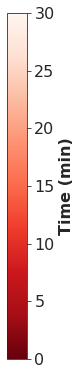

In [168]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(0.35, 8))
img = pl.imshow(a, cmap="Reds_r")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
cbar = pl.colorbar(orientation="vertical", cax=cax,ticks=np.linspace(0,1,7),label='Time (min)')
cbar.ax.set_yticklabels(np.array([0,5,10,15,20,25,30],dtype=int))  # vertically oriented colorbar

plt.savefig('./plots/paper/time_colorbar.pdf', facecolor='white', transparent=True, bbox_inches='tight')
# a = np.array([[0,1]])
# pl.figure(figsize=(9, 1.5))
# img = pl.imshow(a, cmap="Blues")
# pl.gca().set_visible(False)
# cax = pl.axes([0.1, 0.2, 0.8, 0.6])
# pl.colorbar(orientation="h", cax=cax,ticks=start_times)

In [ ]:
area = 'VISp'
for jj, depthstr in enumerate(['superficial','deep']):
    locstr = '{}_{}'.format(area,depthstr)

    X = PSTH_sequence_dict[locstr]
    X = st.zscore(X,axis=0)

    fpath = './plots/paper/pca2D_ABCD_across-sequence-block_pseudopop_{}.pdf'.format(locstr)

#         ax = fig.add_subplot(2, 3, counter, projection='3d'); counter+=1
    fig = dim_reduction_plot_sequence(X, method='pca',nLatents=2,pdfdoc=None)
    plt.title(locstr)
    plt.savefig(fpath, facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:


# area = 'VISp'; depthstr = 'superficial'
# locstr = '{}_{}'.format(area,depthstr)
# X = PSTH_sequence_dict[locstr]

# X = st.zscore(X,axis=0)
# fig = dim_reduction_plot_sequence(X, method='pca',nLatents=2,pdfdoc=None)
# fig, axes = plt.subplots(2,3,figsize=(12,8),sharey=True,sharex=True)
for ii, area in enumerate(areanames):
    #Loop over depth as well
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        
        X = PSTH_sequence_dict[locstr]
        X = st.zscore(X,axis=0)
        
        fpath = './plots/paper/pca3D_ABCD_across-sequence-block_pseudopop_{}.pdf'.format(locstr)

#         ax = fig.add_subplot(2, 3, counter, projection='3d'); counter+=1
        fig = dim_reduction_plot_sequence(X, method='pca',nLatents=3,pdfdoc=None)
        plt.title(locstr)
        plt.savefig(fpath, facecolor='white', transparent=True, bbox_inches='tight')


In [ ]:


# area = 'VISp'; depthstr = 'superficial'
# locstr = '{}_{}'.format(area,depthstr)
# X = PSTH_sequence_dict[locstr]

# X = st.zscore(X,axis=0)
# fig = dim_reduction_plot_sequence(X, method='pca',nLatents=2,pdfdoc=None)
# fig, axes = plt.subplots(2,3,figsize=(12,8),sharey=True,sharex=True)
fig = plt.figure(figsize=(12,8))
counter = 1
for ii, area in enumerate(areanames):
    #Loop over depth as well
    for jj, depthstr in enumerate(['superficial','deep']):
        ax = axes[jj,ii]
        locstr = '{}_{}'.format(area,depthstr)
        
        X = PSTH_sequence_dict[locstr]
        X = st.zscore(X,axis=0)
        
#         fpath = './plots/paper/pca2D_ABCD_across-sequence-block_pseudopop_{}.pdf'.format(locstr)

        ax = fig.add_subplot(2, 3, counter, projection='3d'); counter+=1
        dim_reduction_plot_sequence(X, method='pca',nLatents=3,pdfdoc=None,ax=ax)
        ax.set_title(locstr)
# #         plt.savefig(fpath)
        if (ii == 2) & (jj == 1):
            ax.set_xlabel('PC1',fontsize=18);ax.set_ylabel('PC2',fontsize=18);ax.set_zlabel('PC3',fontsize=18)
#         else:
#             axes[jj,ii].set_xlabel('')
            
#         if ii == 0:
#             axes[jj,ii].set_ylabel('PC2',fontsize=18)
#         else:
#             axes[jj,ii].set_ylabel('')

plt.suptitle('Representation drift maintains geometry of main-sequence',fontsize=22)
plt.savefig(os.path.join('./plots/paper','PCA3D_ms-drift.pdf'), facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:


# area = 'VISp'; depthstr = 'superficial'
# locstr = '{}_{}'.format(area,depthstr)
# X = PSTH_sequence_dict[locstr]

# X = st.zscore(X,axis=0)
# fig = dim_reduction_plot_sequence(X, method='pca',nLatents=2,pdfdoc=None)
fig, axes = plt.subplots(2,3,figsize=(12,8),sharey=True,sharex=True)

for ii, area in enumerate(areanames):
    #Loop over depth as well
    for jj, depthstr in enumerate(['superficial','deep']):
        ax = axes[jj,ii]
        locstr = '{}_{}'.format(area,depthstr)
        
        X = PSTH_sequence_dict[locstr]
        X = st.zscore(X,axis=0)
        
#         fpath = './plots/paper/pca2D_ABCD_across-sequence-block_pseudopop_{}.pdf'.format(locstr)
        dim_reduction_plot_sequence(X, method='pca',nLatents=2,pdfdoc=None,ax=axes[jj,ii])
        axes[jj,ii].set_title(locstr)
#         plt.savefig(fpath)
        if jj == 1:
            axes[jj,ii].set_xlabel('PC1',fontsize=18)
        else:
            axes[jj,ii].set_xlabel('')
            
        if ii == 0:
            axes[jj,ii].set_ylabel('PC2',fontsize=18)
        else:
            axes[jj,ii].set_ylabel('')

plt.suptitle('Representation drift maintains geometry of main-sequence',fontsize=22)
plt.savefig(os.path.join('./plots/paper','PCA2D_ms-drift.pdf'), facecolor='white', transparent=True, bbox_inches='tight')

## D vs X

In [ ]:
## D vs X
    
block_str = 'oddball'
classifier = 'SVM'; method = 'kfold'
#Loop over depth as well
for jj, depthstr in enumerate(['superficial','deep']):

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where MS images were presented from the transition control block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='DX')
#         pdb.set_trace()

        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,nKfold=10,clabels=np.arange(2),classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'DvsX_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        
        fig = dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['D','X'],title=locstr,annot=True,clims=[0,1])
    plt.suptitle('Classifying X vs previous D  \n in sequence block, {} classifier'.format(classifier))
    plt.savefig(os.path.join(PlotDir,'DX_decoding_{}-block_{}-areas_{}_{}.png'.format(block_str,depthstr,method,classifier)))

In [ ]:
## D vs X
    
block_str = 'oddball'
classifier = 'SVM'; method = 'kfold'
#Loop over depth as well
for jj, depthstr in enumerate(['superficial','deep']):

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where MS images were presented from the transition control block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='XD')
#         pdb.set_trace()

        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,nKfold=10,clabels=np.arange(2),classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'XvsD_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        
        fig = dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['D','X'],title=locstr,annot=True,clims=[0,1])
    plt.suptitle('Classifying X vs next D \n in sequence block, {} classifier'.format(classifier))
    plt.savefig(os.path.join(PlotDir,'XD_decoding_{}-block_{}-areas_{}_{}.png'.format(block_str,depthstr,method,classifier)))

In [ ]:
method='kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')
    
method='L1O' 
classifier = 'SVM'

slice_list = [slice(0,120),slice(3080,3200),slice(6280,6400)]
slice_str = ['first120','middle120','last120']
slice_str = 'middle120'
block_str = 'oddball'
# for area in areanames:
#     cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
    
#     #Loop over depth as well
#     for depthstr in ['superficial','deep']:
        
area = 'VISp'; depthstr = 'superficial'
cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
locstr = '{}_{}'.format(area,depthstr)
cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

fig, axes = plt.subplots(1,3,figsize=(15,5))
for ii,(sl_val,sl_str) in enumerate(zip(slice_list,slice_str)):
    #Get trials where MS images were presented from the middle of the oddball block
    X_oddball, Y_oddball, _ = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=sl_val)

    if reduce_dim:
        #Reduce dimensionality using PCA
        pca = PCA(n_components=0.99)
        X_pca = pca.fit_transform(X_oddball)
        nComponents_pca = X_pca.shape[-1]

        #Perform cross-validated decoding analysis
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method)

    else:
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method,parallel=True,nProcesses=50)

    fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)


    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['A','B','C','D'],annot=True,title=f'{depthstr.capitalize()} {area}')
#     plt.suptitle('Classifying MS Images for {}, Oddball block, {} classifier'.format(locstr,classifier))
    plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.pdf'.format(sl_str,locstr,method,classifier)))

In [ ]:
pseudopop_responses[block_str].keys()

## Check decoding performance as a function of number of trials used for decoding

In [ ]:
method='kfold'
reduce_dim=False

    
method='kfold' 
classifier = 'SVM'
slice_list = [slice(0,240),slice(3080,3320),slice(6160,6400)]
slice_str = ['first240','middle240','last240']

classifier = 'nearest_neighbor'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
PlotDir = os.path.join(SaveDir,'plots')


    
area = 'RSP'
cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
t0 = time.perf_counter()
results_shf = {}
#Loop over depth as well
for depthstr in ['superficial','deep']:
    locstr = '{}_{}'.format(area,depthstr)
    cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
    cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
    results_shf[locstr] = []
    iEnd_indices = np.concatenate((np.arange(120,1081,120),np.arange(1080,6400,480)))
    for iEnd in iEnd_indices:
        print(iEnd)
        sl_val = slice(0,iEnd)
        
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=sl_val)
        
        shf_indices = np.random.permutation(X_oddball.shape[0])
        
        
#         pdb.set_trace()
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball[shf_indices],Y_oddball[shf_indices],Y_sort[shf_indices],clabels=mainseq_ids,classifier=classifier,method=method,parallel=True,nProcesses=50)
        results_shf[locstr].append((confusion_mat,confusion_z))


#         dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['A','B','C','D'],title=locstr,annot=True)
#         plt.suptitle('{}\nOddball block, {} classifier'.format(locstr,classifier))
# #     plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_{}_{}_{}.png'.format(locstr,method,classifier)))

# print('Elapsed Time: {}'.format(time.perf_counter()-t0))

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

area = 'RSP'
for jj, depthstr in enumerate(['superficial','deep']):
    locstr = '{}_{}'.format(area,depthstr)
    axes[jj].set_title(locstr)
    tmp_list = results_shf[locstr]

    decoding_performance = np.zeros((len(tmp_list),4))

    for index,(cm, cmz) in enumerate(tmp_list):
        decoding_performance[index] = np.diag(cm)

    for index, label in enumerate(ms_labels):
        axes[jj].plot(iEnd_indices,decoding_performance[:,index],'.-',label=label)

#     axes[jj].set_xticks(iEnd_indices)
    axes[jj].set_ylim([0,1])
    axes[jj].legend()

    if jj == 0:
        axes[jj].set_ylabel('Decoding\n Performance')

    axes[jj].set_xlabel('# of trials used for decoding')
        

## Plot PSTH heatmaps

In [ ]:
PlotDir = './plots/20200630_presentation'
mainseq_ids = [68, 78, 13, 26]
oddball_ids = [6, 17, 22, 51, 71, 89, 103, 110, 111, 112]

In [ ]:
fig, axes = plt.subplots(1,6,figsize=(24,12))

are = 'RSP'
area = 'VISp'
iPlot = 0

PSTH_dict = {}
for area in ['VISp','VISpm','RSP']:

    for depthstr in ['superficial','deep']:
        #Get cells that are in the right layer
        cell_ids = pseudopop_responses['oddball'][area].coords['cell_specimen_id'].values

        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

        #Get trials where MS images were presented from the middle of the oddball block
        #Get trials where MS images are presented in the sequence context
        PSTH_full_list = []
        for i in range(7):
            slindy = slice(i*1000,i*1000+120)
#             context_str = 'sequence'; X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy = slindy)
            X, Y, _ = dc.match_trials(pseudopop_normtraces['oddball'][area].loc[:,:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy = slindy)
    
            PSTH_full = []
            for imgID in mainseq_ids:
                indy = np.where(Y == imgID)[0]
                even_trials = indy[::2]; odd_trials = indy[1::2]
    
                PSTH_full.append(np.mean(X[:,indy],axis=1))
            PSTH_full_list.append(np.vstack(PSTH_full))

        
        pdb.set_trace()
#         PSTH_dict[locstr] = np.array(PSTH_full)
        sns.heatmap(PSTHs.T,cmap='RdBu_r',ax=axes[iPlot],vmin=-1,vmax=1,cbar=False,cbar_kws={'shrink':0.5}) #vmin=0,vmax=3,
#         axes[iPlot].set_title(locstr)
#         axes[iPlot].set_yticks([0,len(cell_ids_perdepth)])
#         axes[iPlot].set_yticklabels([0,len(cell_ids_perdepth)])
        
#         nImgs = PSTHs.shape[-1]
#         axes[iPlot].vlines(4,*[0,len(cell_ids_perdepth)],color='w',ls='--')
#         axes[iPlot].set_xticks([2,7])
#         axes[iPlot].set_xticklabels(['MS','X'])""
        iPlot += 1
#     plt.show()
#     pdb.set_trace()

# plt.savefig(f'/home/dwyrick/projects/predictive_coding/plots/paper/PSTHs_heatmap_{context_str}-context_{cstr}.pdf')

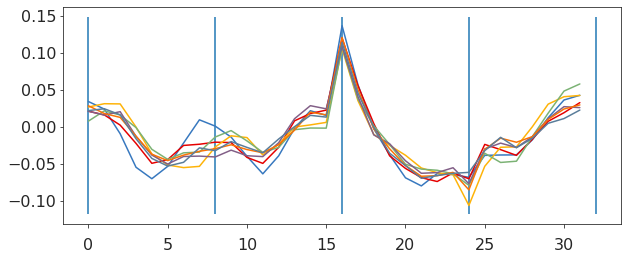

In [140]:
fig, ax = plt.subplots(figsize=(10,4))
for ii,PSTHs in enumerate(PSTH_full_list):
    ax.plot(np.mean(PSTHs,axis=1),color=cc[ii])
ax.vlines(np.linspace(0,32,5),*ax.get_ylim())

IndexError: index 6 is out of bounds for axis 0 with size 6

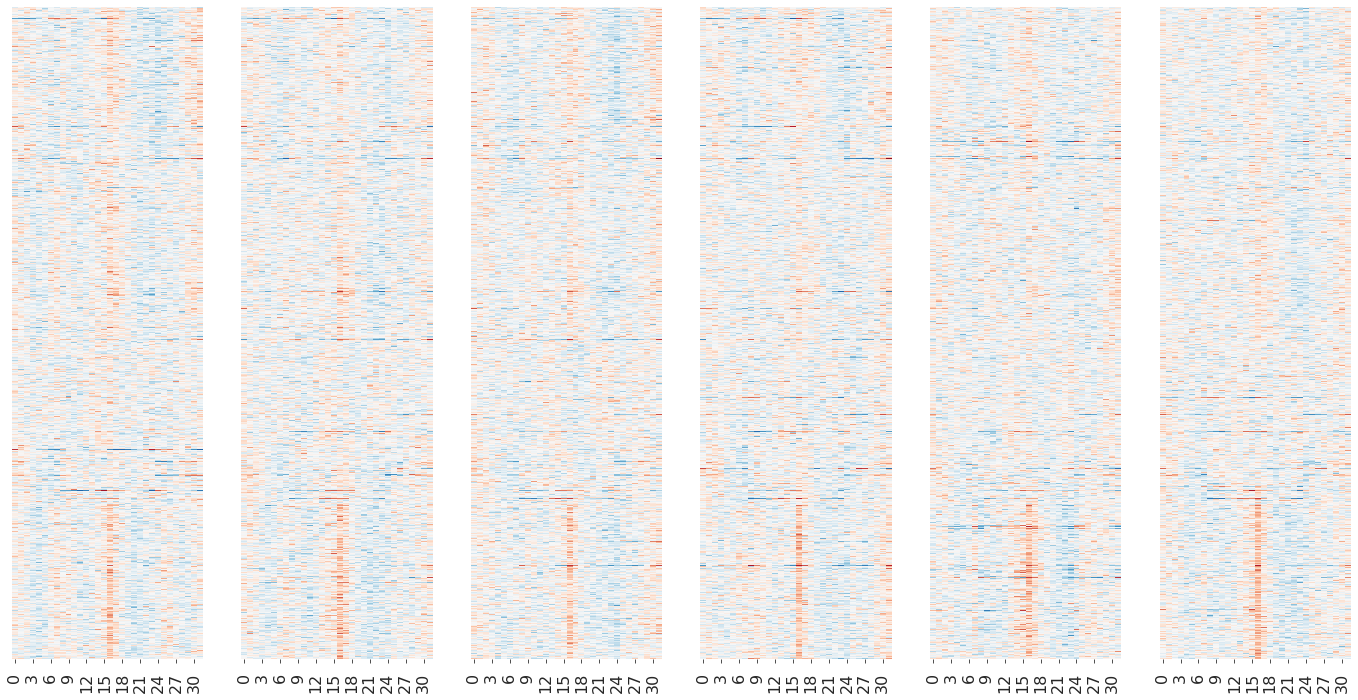

In [143]:
fig, axes = plt.subplots(1,6,figsize=(24,12))
for ii,PSTHs in enumerate(PSTH_full_list):
    sns.heatmap(PSTHs.T,cmap='RdBu_r',ax=axes[ii],vmin=-1,vmax=1,cbar=False,cbar_kws={'shrink':0.5}) #vmin=0,vmax=3,
    axes[ii].set_yticks([])
    

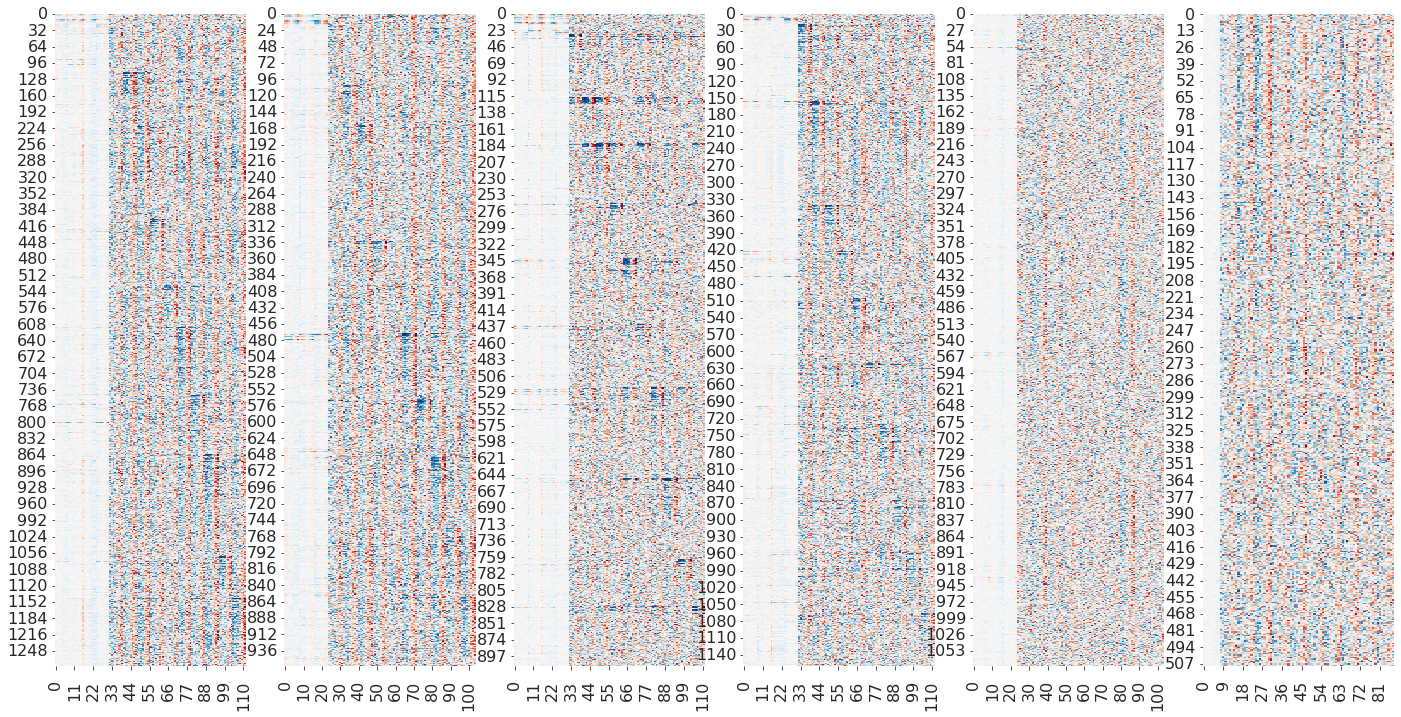

In [99]:
fig, axes = plt.subplots(1,6,figsize=(24,12))

are = 'RSP'
area = 'VISp'
iPlot = 0

PSTH_dict = {}
for area in ['VISp','VISpm','RSP']:

    for depthstr in ['superficial','deep']:
        #Get cells that are in the right layer
        cell_ids = pseudopop_responses['oddball'][area].coords['cell_specimen_id'].values

        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

        #Get trials where MS images were presented from the middle of the oddball block
#         context_str = 'trans-ctrl'; X, Y, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
#         context_str = 'rand-ctrl0'; X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
        context_str = 'sequence'; X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')
#         context_str = 'sequence'; X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')

        X2, Y, _ = dc.match_trials(pseudopop_normtraces['oddball'][area].loc[:,:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')
        cell_list = []; cell_full_list = []
        PSTH_odd_list = []; PSTH_even_list = []; PSTH_full = []
        for imgID in mainseq_ids:
            #Get cell ids that prefer that image
            cellIDs_pref = cell_metadata_df.loc[(cell_metadata_df['pref_stim'] == imgID) & (cell_metadata_df['location'] == locstr)].index.values
            if len(cellIDs_pref) == 0:
                continue
            indy = np.where(Y == imgID)[0]
            even_trials = indy[::2]
            odd_trials = indy[1::2]
            
            mean_response = np.mean(X[even_trials],axis=0)
            ss = np.argsort(np.array(mean_response.loc[cellIDs_pref]))[::-1]
            cell_list.append(cellIDs_pref[ss])
            
            mean_response = np.mean(X[indy],axis=0)
            ss = np.argsort(np.array(mean_response.loc[cellIDs_pref]))[::-1]
            cell_full_list.append(cellIDs_pref[ss])
            
            PSTH_even_list.append(np.mean(X2[:,even_trials],axis=1))            
            PSTH_odd_list.append(np.mean(X2[:,odd_trials],axis=1))
            PSTH_full.append(np.mean(X2[:,indy],axis=1))

        #Get trials where MS images were presented from the middle of the oddball block
#         context_str = 'trans-ctrl'; X, Y, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')
#         context_str = 'rand-ctrl0'; X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='X')
        context_str = 'rand-ctrl1'; X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')
#         context_str = 'sequence'; X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')

        context_str = 'rand-ctrl1'; X2, Y, _ = dc.match_trials(pseudopop_normtraces['oddball'][area].loc[:,:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')
        for imgID in oddball_ids:
            #Get cell ids that prefer that image
            cellIDs_pref = cell_metadata_df.loc[(cell_metadata_df['pref_stim'] == imgID) & (cell_metadata_df['location'] == locstr)].index.values
            if len(cellIDs_pref) == 0:
                continue
            indy = np.where(Y == imgID)[0]
            
            even_trials = indy[::2]
            odd_trials = indy[1::2]
            
            mean_response = np.mean(X[even_trials],axis=0)
            ss = np.argsort(np.array(mean_response.loc[cellIDs_pref]))[::-1]
            cell_list.append(cellIDs_pref[ss])
            
            mean_response = np.mean(X[indy],axis=0)
            ss = np.argsort(np.array(mean_response.loc[cellIDs_pref]))[::-1]
            cell_full_list.append(cellIDs_pref[ss])
            
            
            PSTH_even_list.append(np.mean(X2[:,even_trials],axis=1))            
            PSTH_odd_list.append(np.mean(X2[:,odd_trials],axis=1))
            PSTH_full.append(np.mean(X2[:,indy],axis=1))

        cstr = 'corrected'
#         pdb.set_trace()        
        if cstr == 'corrected':
            ordered_cellIDs =  np.concatenate(cell_list)
#             PSTHs_even = np.vstack(PSTH_even_list)
            PSTH_list = []
            for psth in PSTH_odd_list:
                PSTH_list.append(psth.loc[:,ordered_cellIDs])
            PSTHs = np.vstack(PSTH_list)
            
        else:
            ordered_cellIDs =  np.concatenate(cell_full_list)
            PSTH_list = []
            for psth in PSTH_full:
                PSTH_list.append(psth.loc[:,ordered_cellIDs])
            PSTHs = np.vstack(PSTH_list)
            
#         pdb.set_trace()
#         PSTH_dict[locstr] = np.array(PSTH_full)
        sns.heatmap(PSTHs.T,cmap='RdBu_r',ax=axes[iPlot],vmin=-1,vmax=1,cbar=False,cbar_kws={'shrink':0.5}) #vmin=0,vmax=3,
#         axes[iPlot].set_title(locstr)
#         axes[iPlot].set_yticks([0,len(cell_ids_perdepth)])
#         axes[iPlot].set_yticklabels([0,len(cell_ids_perdepth)])
        
#         nImgs = PSTHs.shape[-1]
#         axes[iPlot].vlines(4,*[0,len(cell_ids_perdepth)],color='w',ls='--')
#         axes[iPlot].set_xticks([2,7])
#         axes[iPlot].set_xticklabels(['MS','X'])""
        iPlot += 1
#     plt.show()
#     pdb.set_trace()

# plt.savefig(f'/home/dwyrick/projects/predictive_coding/plots/paper/PSTHs_heatmap_{context_str}-context_{cstr}.pdf')

In [ ]:
fig, axes = plt.subplots(1,6,figsize=(24,12))

are = 'RSP'
area = 'VISp'
iPlot = 0

PSTH_dict = {}
for area in ['VISp','VISpm','RSP']:

    for depthstr in ['superficial','deep']:
        #Get cells that are in the right layer
        cell_ids = pseudopop_responses['oddball'][area].coords['cell_specimen_id'].values

        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

        #Get trials where MS images were presented from the middle of the oddball block
#         context_str = 'trans-ctrl'; X, Y, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
#         context_str = 'rand-ctrl-pre'; X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
#         context_str = 'rand-ctrl-post'; X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_post'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
        context_str = 'sequence'; X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')

        PSTH_list = []
        cell_list = []
        for imgID in mainseq_ids:
            indy = np.where(Y == imgID)[0]
            even_trials = indy[::2]
            odd_trials = indy[1::2]
            mean_response = np.mean(X[indy],axis=0)

            PSTH_list.append(mean_response)

        #Get trials where MS images were presented from the middle of the oddball block
#         context_str = 'trans-ctrl'; X, Y, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')
#         context_str = 'rand-ctrl-pre'; X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='X')
#         context_str = 'rand-ctrl-post'; X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_post'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='X')
        context_str = 'sequence'; X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')


        for imgID in oddball_ids:
            #Get cell ids that prefer that image

            indy = np.where(Y == imgID)[0]
            
            even_trials = indy[::2]
            odd_trials = indy[1::2]
            mean_response = np.mean(X[indy],axis=0)
            PSTH_list.append(mean_response)

        PSTHs = np.stack(PSTH_list,axis=1)
        mz = np.max(PSTHs,axis=1)
        indy = np.argsort(mz)
        ordered_PSTH = PSTHs[indy]
        
        
        sns.heatmap(PSTHs[indy],cmap='viridis',ax=axes[iPlot],vmin=0,vmax=2,cbar_kws={'shrink':0.5}) #vmin=0,vmax=3,
        axes[iPlot].set_title(locstr)
        axes[iPlot].set_yticks([0,len(cell_ids_perdepth)])
        axes[iPlot].set_yticklabels([0,len(cell_ids_perdepth)])
        
        nImgs = PSTHs.shape[-1]
        axes[iPlot].vlines(4,*[0,len(cell_ids_perdepth)],color='w',ls='--')
        axes[iPlot].set_xticks([2,7])
        axes[iPlot].set_xticklabels(['MS','X'])
        iPlot += 1
#     plt.show()
#     pdb.set_trace()

# plt.savefig(f'/home/dwyrick/projects/predictive_coding/plots/paper/PSTHs_heatmap_{context_str}-context_uncorrected.pdf')

In [ ]:
fig, axes = plt.subplots(1,6,figsize=(24,12))

are = 'RSP'
area = 'VISp'
iPlot = 0

PSTH_dict = {}
for area in ['VISp','VISpm','RSP']:

    for depthstr in ['superficial','deep']:
        #Get cells that are in the right layer
        cell_ids = pseudopop_responses['oddball'][area].coords['cell_specimen_id'].values

        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

        #Get trials where MS images were presented from the middle of the oddball block
#         context_str = 'trans-ctrl'; X, Y, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
#         context_str = 'rand-ctrl-pre'; X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
#         context_str = 'rand-ctrl-post'; X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_post'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
        context_str = 'sequence'; X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')

        PSTH_odd_list = []
        PSTH_even_list = []
        for imgID in mainseq_ids:
            indy = np.where(Y == imgID)[0]
            even_trials = indy[::2]
            odd_trials = indy[1::2]
            
            PSTH_odd_list.append(np.mean(X[odd_trials],axis=0))
            PSTH_even_list.append(np.mean(X[even_trials],axis=0))

        #Get trials where MS images were presented from the middle of the oddball block
#         context_str = 'trans-ctrl'; X, Y, _ = dc.match_trials(pseudopop_responses['transition_control'][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')
#         context_str = 'rand-ctrl-pre'; X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_pre'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='X')
#         context_str = 'rand-ctrl-post'; X, Y, _ = dc.match_trials(pseudopop_responses['randomized_control_post'][area].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='X')
        context_str = 'sequence'; X, Y, _ = dc.match_trials(pseudopop_responses['oddball'][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')


        for imgID in oddball_ids:
            indy = np.where(Y == imgID)[0]
            even_trials = indy[::2]
            odd_trials = indy[1::2]
            
            PSTH_odd_list.append(np.mean(X[odd_trials],axis=0))
            PSTH_even_list.append(np.mean(X[even_trials],axis=0))

        PSTHs_odd = np.stack(PSTH_odd_list,axis=1)
        PSTHs_even = np.stack(PSTH_even_list,axis=1)
        mz = np.max(PSTHs_odd,axis=1)
        indy = np.argsort(mz)[::-1]
        ordered_PSTH = PSTHs_even[indy]
        
        
        sns.heatmap(PSTHs_odd[indy],cmap='viridis',ax=axes[iPlot],cbar_kws={'shrink':0.5}) #vmin=0,vmax=3,
        axes[iPlot].set_title(locstr)
        axes[iPlot].set_yticks([0,len(cell_ids_perdepth)])
        axes[iPlot].set_yticklabels([0,len(cell_ids_perdepth)])
        
        nImgs = PSTHs.shape[-1]
        axes[iPlot].vlines(4,*[0,len(cell_ids_perdepth)],color='w',ls='--')
        axes[iPlot].set_xticks([2,7])
        axes[iPlot].set_xticklabels(['MS','X'])
        iPlot += 1
#     plt.show()
#     pdb.set_trace()

# plt.savefig(f'/home/dwyrick/projects/predictive_coding/plots/paper/PSTHs_heatmap_{context_str}-context_uncorrected.pdf')

## Oddball images from the random control block

In [ ]:
method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')
    
for iP2, pstr in enumerate(['pre','post']):
    block_str = 'randomized_control_{}'.format(pstr)
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:

        fig, axes = plt.subplots(1,3,figsize=(15,5))
        for ii,area in enumerate(areanames):
            cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values

            locstr = '{}_{}'.format(area,depthstr)
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

            #Get trials where MS images were presented from the randomized_ccontrol block
            X_randctrl, Y_randctrl, Y_sort = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')
            
#             pdb.set_trace()
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X_oddball)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,method=method,nKfold=10,clabels=oddball_ids,classifier=classifier)

            else:
                #Use pseudopopulation vectors for decoding
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_randctrl,Y_randctrl,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=oddball_ids)

            fpath = os.path.join(SaveDir,'X-img_decoding_rand-ctrl-{}-block_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

    #         with h5py.File(fpath,'r') as h5file:
    #             confusion_mat = np.array(h5file['confusion_mat'])
    #             confusion_z = np.array(h5file['confusion_z'])

            dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=np.arange(10),title=locstr,annot=False)
        plt.suptitle('Classifying Oddball Images for transition control {} block, {} classifier'.format(pstr,classifier),y=0.925)
        plt.savefig(os.path.join(PlotDir,'X-img_decoding_rand-ctrl-{}-blocks_{}-areas_{}_{}.png'.format(pstr,depthstr,method,classifier)))

## Oddball images from the transition control block

In [ ]:

method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')

classifier = 'SVM'; method = 'kfold'
block_str='transition_control'

#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where odbball images were presented from the transition_control block
        X_transctrl, Y_transctrl, _ = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')
#         pdb.set_trace()
        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_transctrl)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_transctrl,clabels=oddball_ids,classifier=classifier,method=method)

        else:
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_transctrl,Y_transctrl,method='kfold',nKfold=10,classifier=classifier,clabels=oddball_ids,parallel=True,nProcesses=75)

        fpath = os.path.join(SaveDir,'X-img_decoding_transition-ctrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

#         with h5py.File(fpath,'r') as h5file:
#             confusion_mat = np.array(h5file['confusion_mat'])
#             confusion_z = np.array(h5file['confusion_z'])

        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=np.arange(10),title=locstr,annot=False)
    plt.suptitle('Classifying Oddball Images for transition control, {} classifier'.format(classifier),y=0.925)
    plt.savefig(os.path.join(PlotDir,'X-img_decoding_transctrl-blocks_{}_{}_{}.png'.format(locstr,method,classifier)))

## Oddball images from the oddball block

In [ ]:
method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')

classifier = 'SVM'; method = 'kfold'
block_str='oddball'

#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        print(locstr,'...')
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')
#         pdb.set_trace()
        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,method=method,nKfold=10,clabels=oddball_ids,classifier=classifier)

        else:
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=oddball_ids,parallel=True,nProcesses=50)

        print('Done')
        fpath = os.path.join(SaveDir,'X-img_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

#         with h5py.File(fpath,'r') as h5file:
#             confusion_mat = np.array(h5file['confusion_mat'])
#             confusion_z = np.array(h5file['confusion_z'])

        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=np.arange(10),title=locstr,annot=False)
    plt.suptitle('Classifying Oddball Images for oddball block, {} classifier'.format(classifier),y=0.925)
    plt.savefig(os.path.join(PlotDir,'X-img_decoding_oddball-blocks_{}_{}_{}.png'.format(locstr,method,classifier)))

### Try to decode oddball images vs the previous main sequence in the oddball block
ABCD---X; i.e. the ABC trials are as far away from an oddball presentation as possible

In [ ]:
classifier = 'nearest_neighbor'

method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')
    
#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        print(locstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
 
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCDX')
        
        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

        else:
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])
            

        fpath = os.path.join(SaveDir,'prevMSvsX_decoding_oddball-block_{}_{}.mat'.format(locstr,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
        
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D','X'],title=locstr,annot=True)
    plt.suptitle('Oddball vs Previous Main-Sequence Images, ABCD---X, {} classifier'.format(classifier))
    plt.savefig(os.path.join(PlotDir,'prevMSvsX_decoding_oddball-blocks_{}-areas_{}.png'.format(depthstr,classifier)))

### Try to decode oddball images vs the main sequence immediately following the oddball
XABCD i.e. the ABCD trials are as close to the oddball presentations as possible

In [ ]:
method = 'kfold'; classifier = 'SVM'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
    PlotDir = os.path.join(SaveDir,'plots')

block_str='oddball'
#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = pseudopop_responses[block_str][area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(pseudopop_responses[block_str][area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='XABCD')

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

        else:
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

        fpath = os.path.join(SaveDir,'nextMSvsX_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D','X'],title=locstr,annot=True)
    plt.suptitle('Oddball vs Next Main-Sequence Images, XABCD, {} classifier'.format(classifier))
    plt.savefig(os.path.join(PlotDir,'nextMSvsX_decoding_oddball-blocks_{}-areas_{}_{}.pdf'.format(depthstr,method,classifier)))